# Potential locations for vertiports such as gas stations, helipads etc. in Paris

In this notebook, various data is prepared for subsequent suitability analysis of potential locations for vertiports which can be used for UAM infrastructure in Paris. In general, vector data for gas stations, heli pads and other potential locations are taken from Open Street Map (OSM). Subsequently, the vector data is combined with other data sources which most likely influence the suitability of the given locations for UAM ground infrastructure. The factors that are taken into account for the suitability analysis are: population density, median standard of living, job density, noise, number of points of interest nearby, distance to major transport nodes, and potential prohibited airspace also called no-fly zones.

In [1]:
# get gas stations in Paris and surrounding area with OSM python module: pyrosm
from pyrosm import OSM
from pyrosm import get_data
import geopandas as gpd
fp = get_data("Paris")
# Initialize the OSM parser object
osm = OSM(fp)
myfilter = {'amenity': ['fuel']}
gas_station = osm.get_buildings(custom_filter=myfilter)
# drop non-polygon objects
dropped_rows = len(gas_station.loc[gas_station['geometry'].geom_type.str.contains('Line', case=False), ])
print(f'Number of Linestrings which will be dropped: {dropped_rows}')
gas_station = gas_station.loc[~gas_station['geometry'].geom_type.str.contains('Line', case=False), ]
gas_station = gas_station[['id', 'geometry']]

Number of Linestrings which will be dropped: 3


In [2]:
# get helipads and heliports in Paris and surrounding area
helipads = osm.get_data_by_custom_criteria(custom_filter={'aeroway':['helipad', 'heliport']},
                                          # Keep data matching the criteria above
                                          filter_type="keep")
# drop non-polygon objects
dropped_rows = len(helipads.loc[helipads['geometry'].geom_type.str.contains('Line', case=False), ])
print(f'Number of Linestrings which will be dropped: {dropped_rows}')
helipads = helipads.loc[~helipads['geometry'].geom_type.str.contains('Line', case=False), ]
helipads = helipads[['id', 'geometry']]
x = sum(helipads['id'].isin(list(gas_station['id'])))
if x == 0:
    gas_station = gas_station.append(helipads, ignore_index=True)
else:
    print("A helipad and a gas station must have the same OSM_id")

Number of Linestrings which will be dropped: 0


In [3]:
gas_station.shape

(15156, 2)

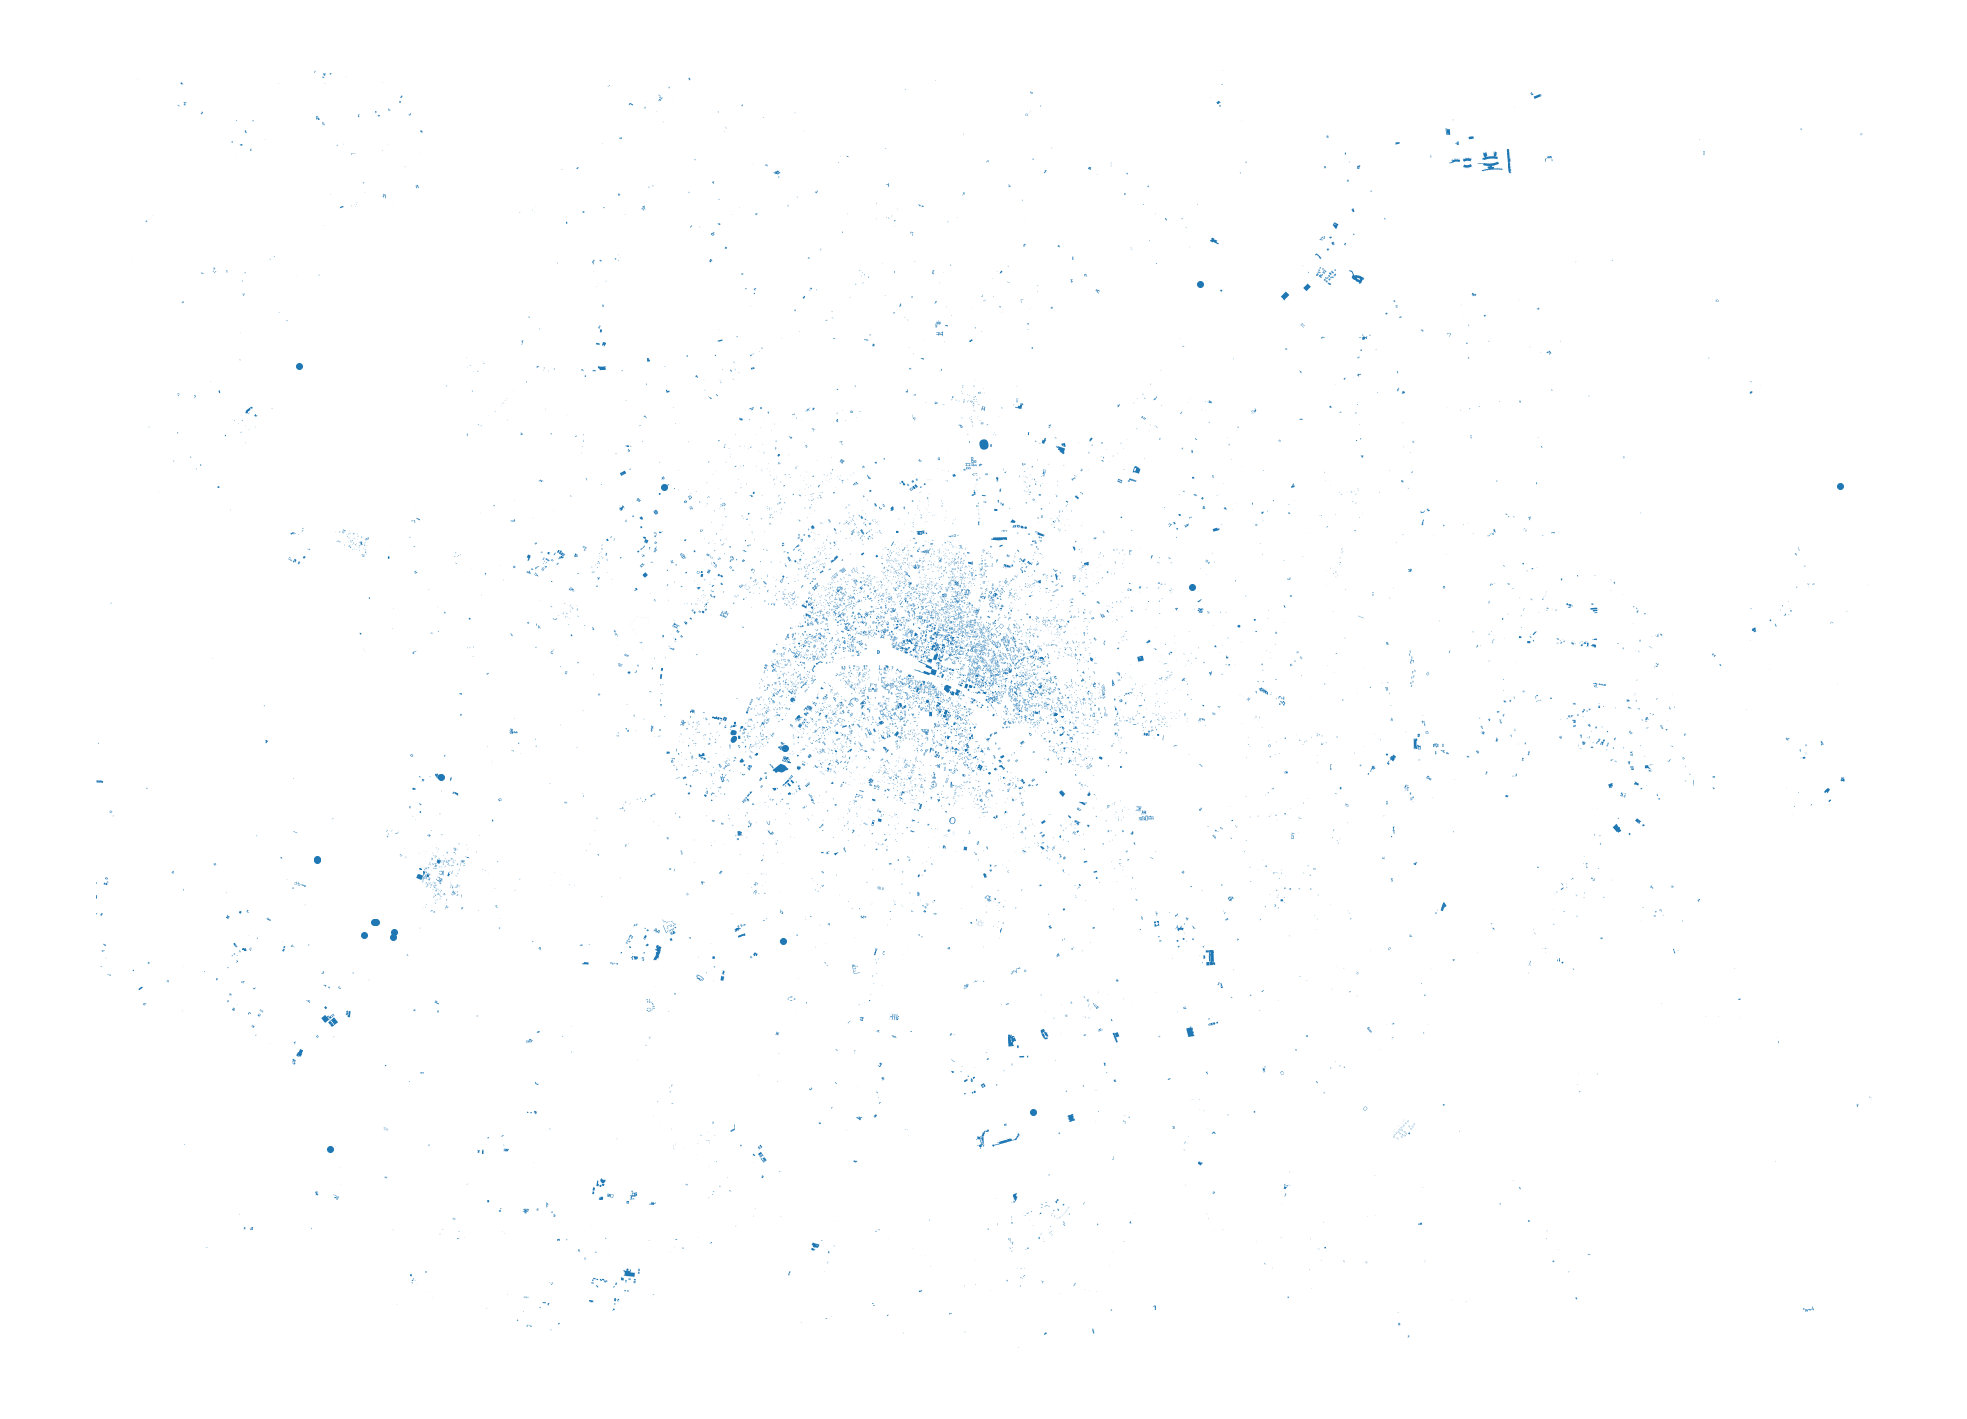

In [4]:
# Plot gas stations and helipads
ax = gas_station.plot(figsize=[35,35])
ax.set_axis_off()

In [5]:
gas_station.head()

id                                           geometry
0  24285905  POLYGON ((2.53635 49.00893, 2.53818 49.00928, ...
1  26334246  POLYGON ((2.45146 48.88020, 2.45333 48.88102, ...
2  31964247  POLYGON ((2.31329 48.91938, 2.31330 48.91939, ...
3  44071041  POLYGON ((2.49546 48.94494, 2.49592 48.94452, ...
4  45250985  POLYGON ((2.50439 48.69478, 2.50439 48.69469, ...

# Population density

The population density data is taken from eurostat and can befound here: https://ec.europa.eu/eurostat/de/web/gisco/geodata/reference-data/population-distribution-demography/geostat#geostat11

The dataset entails population density data in vector format (per 1km x 1km) for the entire EU from the last census in 2018.

In [6]:
import geopandas as gpd
df = gpd.read_file('EU_popdata/JRC_POPULATION_2018.shp')

In [7]:
# Select only France from the population density data and save the intersection on gas stations
france = df.loc[df['CNTR_ID'] == 'FR']
print(france.crs)
gas_station = gas_station.to_crs(epsg=3035)
if gas_station.crs == france.crs:
    gas_station = gpd.sjoin(gas_station, france, op='intersects', how='left')
    gas_station['TOT_P_2018'].isnull().sum()
else:
    print('The projections do not match!')

epsg:3035


It is possible that a gas station polygon intersects with more than one of the population density polygons. In this case, the arithmetic mean of the population densities affected will be taken to determine the population density around the gas station of interest.

In [8]:
# Group density by id and calculate density mean
density_mean = gas_station.groupby('id', as_index=False)['TOT_P_2018'].mean()
density_mean.isnull().sum()

id             0
TOT_P_2018    59
dtype: int64

In [9]:
# merge gas stations with the mean-densities. Then drop the duplicates
gas_station = gas_station.merge(density_mean, on='id', how='left')

#print(f'Example: {gas_station.loc[gas_station['id'] == 367900743629, ]}')
gas_station = gas_station.drop_duplicates(subset= ['id'], keep='first')
gas_station = gas_station[['id', 'geometry', 'TOT_P_2018_y']]
gas_station.columns = ['id', 'geometry', 'TOT_P_2018']
print(f'Number of Nans: {gas_station.isnull().sum()}')
print(gas_station.crs)
print(gas_station.shape)

Number of Nans: id             0
geometry       0
TOT_P_2018    59
dtype: int64
epsg:3035
(15156, 3)


In [10]:
gas_station.rename(columns={'TOT_P_2018': 'Population_density'}, inplace=True)
gas_station.head()

id                                           geometry  \
0  24285905  POLYGON ((3775888.076 2904965.056, 3776025.449...   
1  26334246  POLYGON ((3768276.452 2891346.568, 3768421.887...   
2  31964247  POLYGON ((3758646.508 2896730.118, 3758646.973...   
3  44071041  POLYGON ((3772203.380 2898184.237, 3772232.564...   
4  45250985  POLYGON ((3770085.960 2870423.888, 3770085.274...   

   Population_density  
0                 NaN  
1              8013.0  
2              4015.0  
3              9724.0  
4              4510.0

In [11]:
# This is only used for plotting 
# clips population data into area of interest and identifies which areas have high population density
from shapely.geometry import Polygon

area_of_interest = Polygon([(1.84, 48.5257), (1.84, 49.1907), (2.9581, 49.1907), (2.9581,48.5257)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[area_of_interest], crs=4326)
poly_gdf = poly_gdf.to_crs(epsg=3035)
france = france.to_crs(epsg=3035)
clipped_pop_density = gpd.clip(france, poly_gdf)
clipped_pop_density = clipped_pop_density.astype({'TOT_P_2018': 'float64'})
clipped_pop_density.sort_values(by=['TOT_P_2018'], ascending=False, inplace=True)
top10p = round(len(clipped_pop_density.index)*0.1)

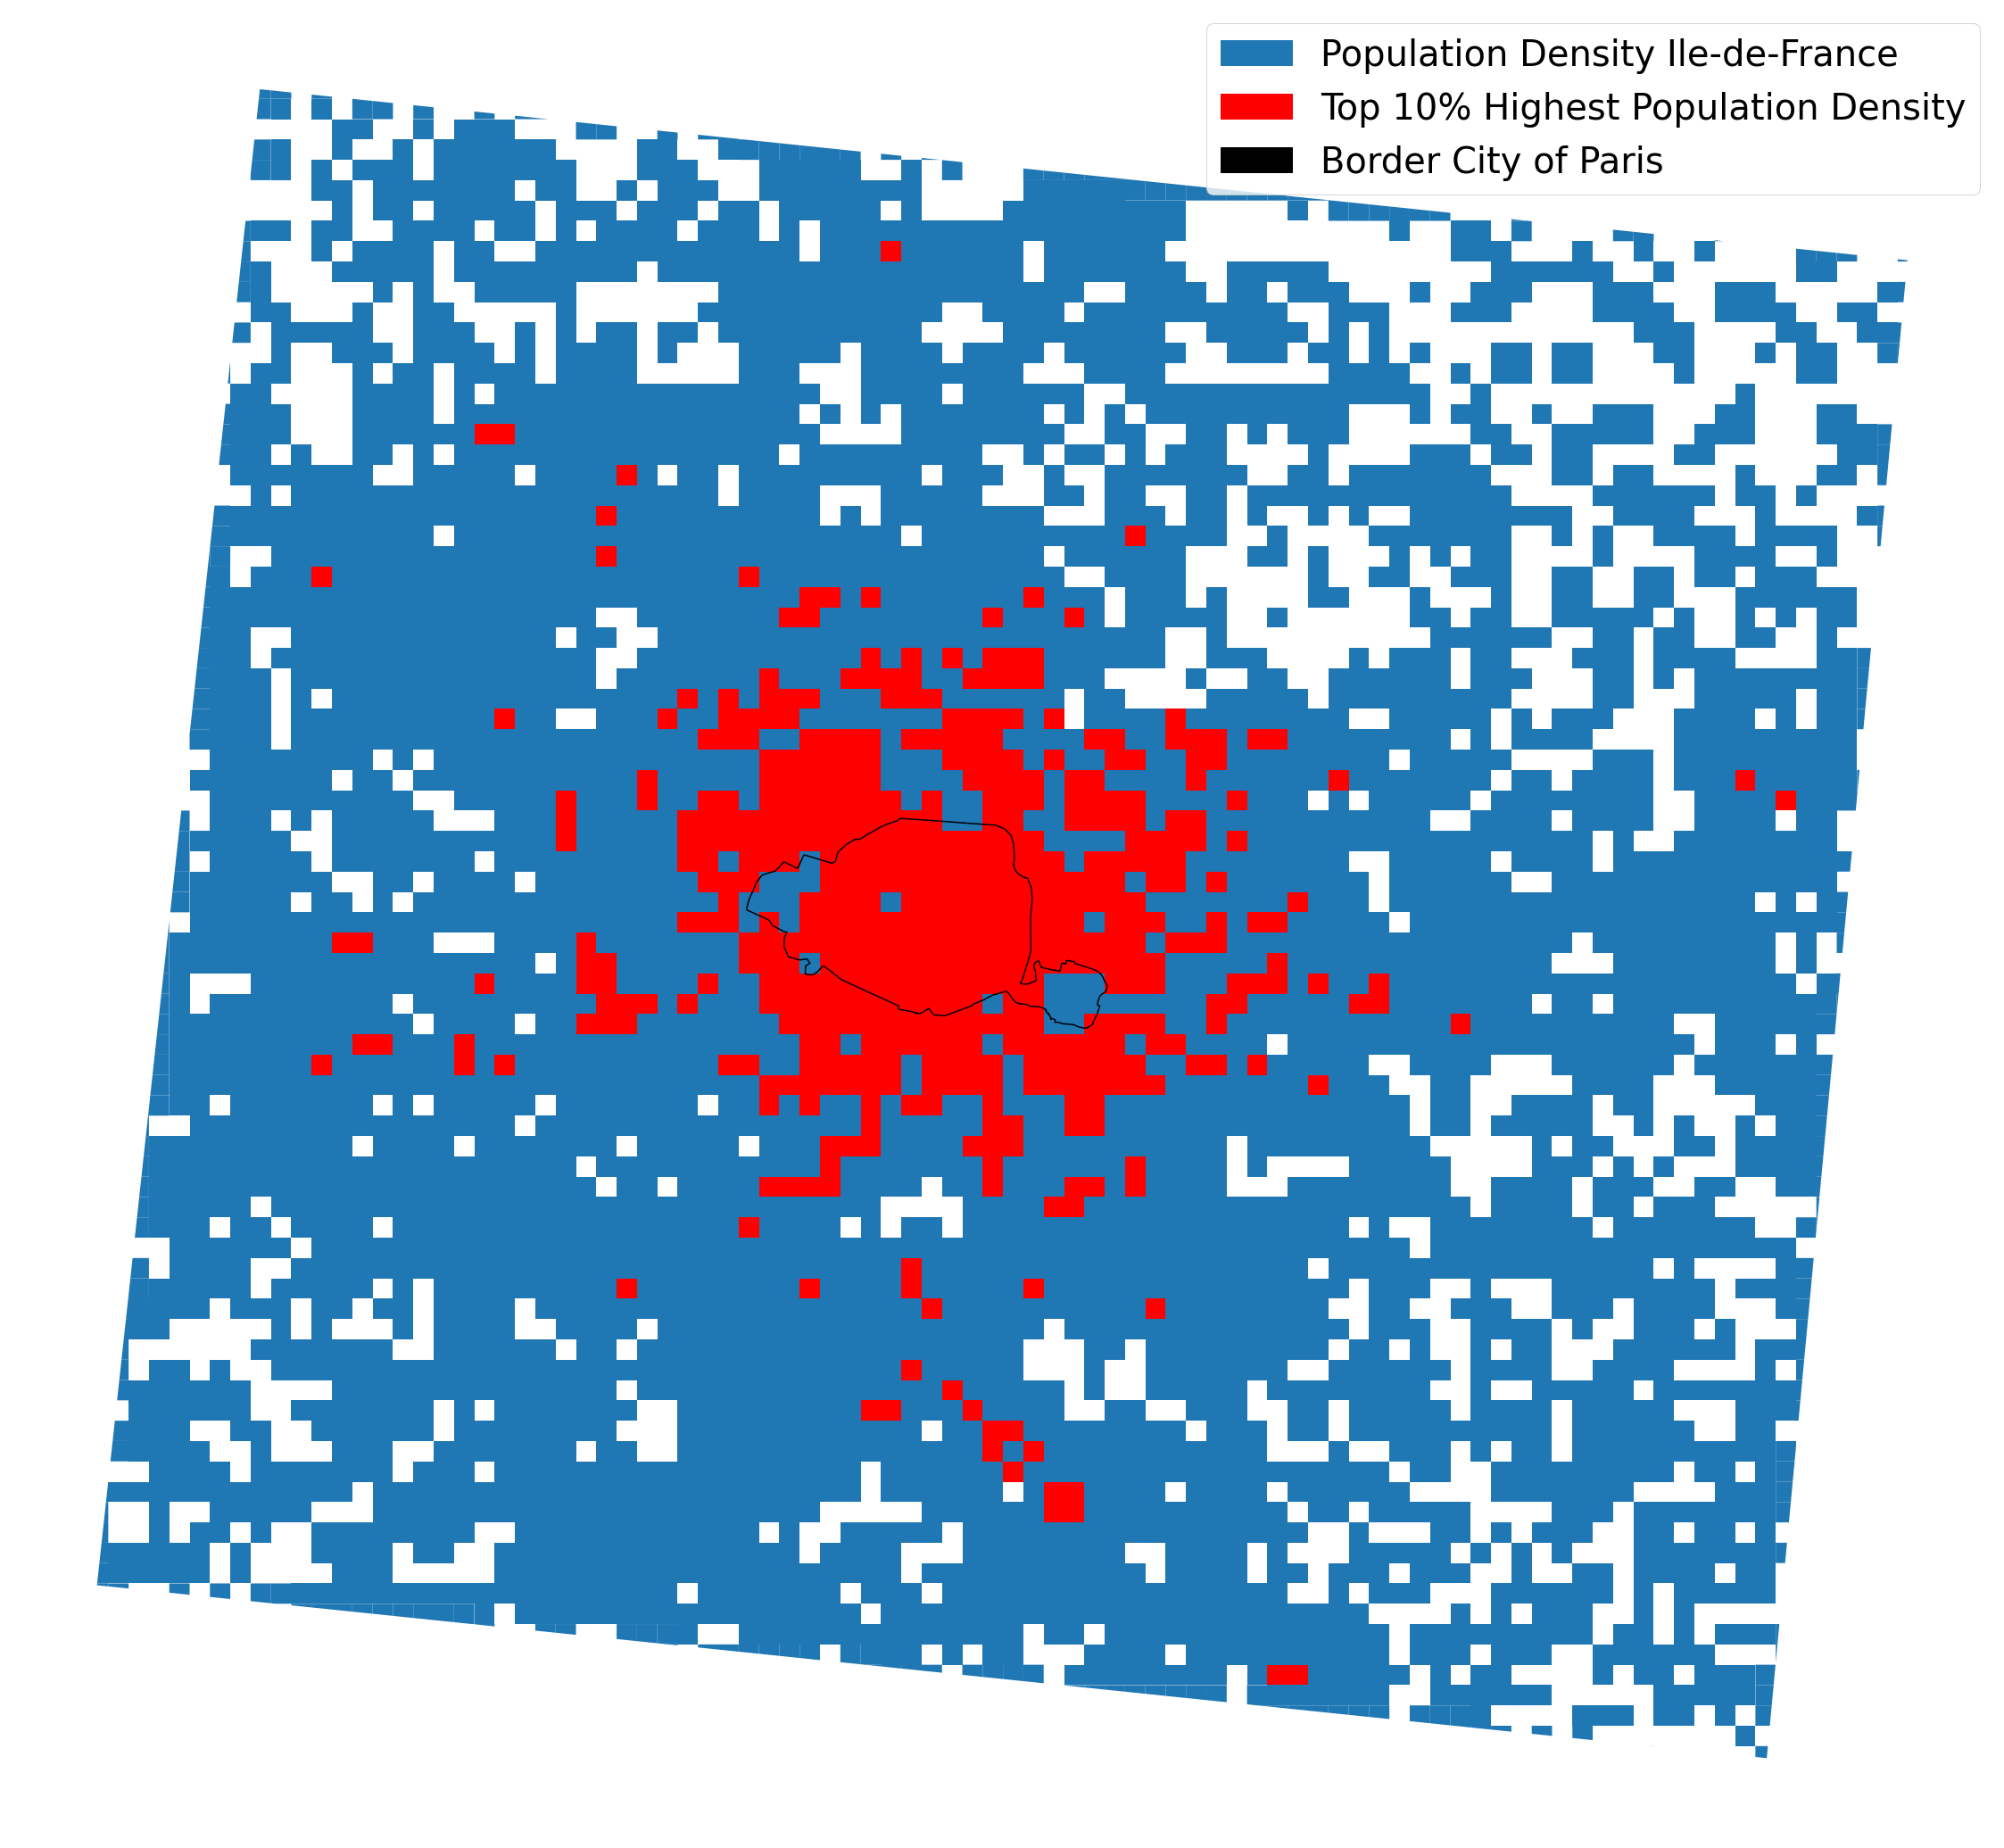

In [12]:
# plot 10% highest pop density 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

paris_border = gpd.read_file('paris_boundary.shp')
top10p_popdensity = clipped_pop_density.iloc[0:top10p,:]

ax = clipped_pop_density.plot(figsize=[40,40])
top10p_popdensity.plot(ax=ax, color='red')
paris_border.plot(ax=ax, color='black')
blue_patch = mpatches.Patch(color='#1f77b4', label='Population Density Ile-de-France')
red_patch = mpatches.Patch(color='red', label='Top 10% Highest Population Density')
black_patch = mpatches.Patch(color='black', label='Border City of Paris')
plt.legend(handles=[blue_patch, red_patch, black_patch], prop={'size': 40})
ax.set_axis_off()

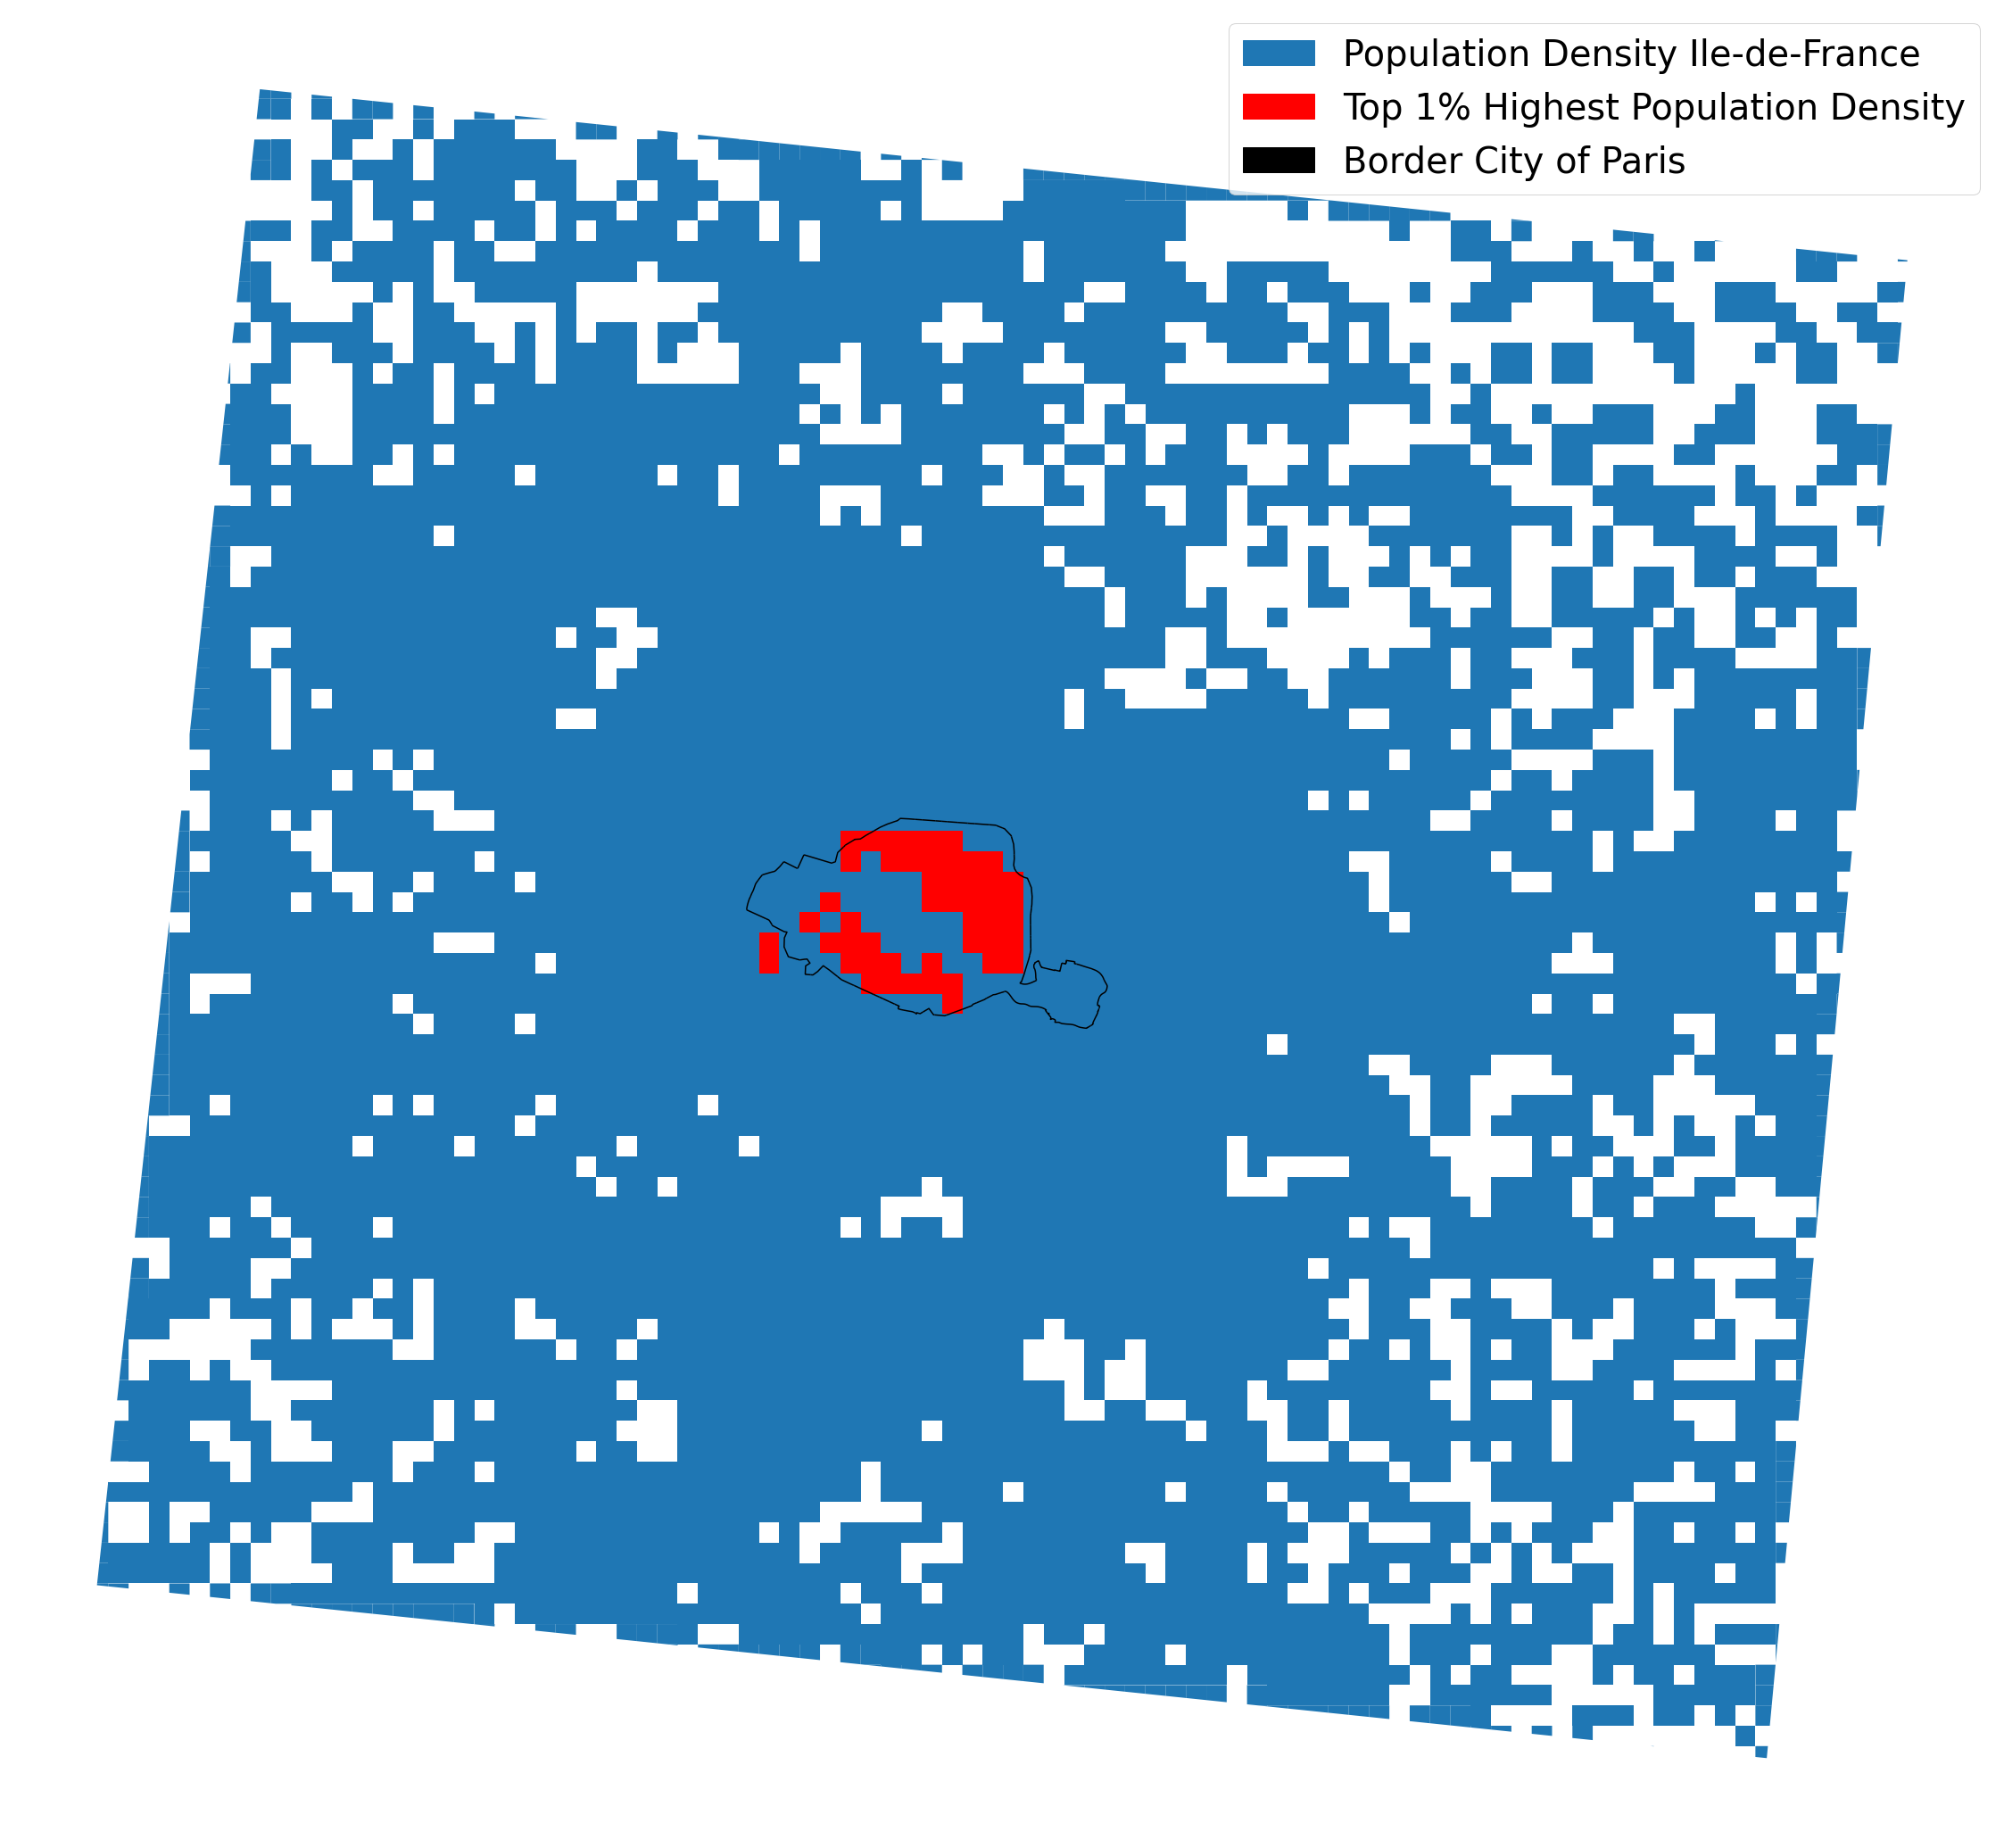

In [13]:
# plot 1% highest pop density 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

paris_border = gpd.read_file('paris_boundary.shp')
top1p = round(len(clipped_pop_density.index)*0.01)
top1p_popdensity = clipped_pop_density.iloc[0:top1p,:]

ax = clipped_pop_density.plot(figsize=[40,40])
paris_border.plot(ax=ax, color='black')
top1p_popdensity.plot(ax=ax, color='red')
blue_patch = mpatches.Patch(color='#1f77b4', label='Population Density Ile-de-France')
red_patch = mpatches.Patch(color='red', label='Top 1% Highest Population Density')
black_patch = mpatches.Patch(color='black', label='Border City of Paris')
plt.legend(handles=[blue_patch, red_patch, black_patch], prop={'size': 40})
ax.set_axis_off()
#top1p_popdensity.to_file('EU_popdata/top1percent_population_density.shp')

# Median standard of living and job density
The data is taken from the institut national de la statistique et des études économiques (Insee) and can befound here:

Median Standard of Living (2017): https://www.insee.fr/fr/statistiques/4507225?sommaire=4507229

Job density (2018): https://www.insee.fr/fr/statistiques/4990792#consulter
Data description: https://www.insee.fr/en/metadonnees/source/serie/s1042

In [14]:
iledeFrance = gpd.read_file('medianliving_and_jobdensity/Ile-de-France.shp')
paris = gpd.read_file('medianliving_and_jobdensity/Paris_Arrondissements.shp')

In [15]:
paris.head()

name ref_INSEE  MED17 Job_densit  \
0  Paris 16e Arrondissement     75116  38900     105049   
1  Paris 17e Arrondissement     75117  30800     109566   
2  Paris 15e Arrondissement     75115  30880     156255   
3   Paris 7e Arrondissement     75107  43270      78266   
4  Paris 14e Arrondissement     75114  27680      79623   

                                            geometry  
0  POLYGON ((3755742.048 2892479.119, 3755753.797...  
1  POLYGON ((3758912.379 2894585.501, 3758949.844...  
2  POLYGON ((3754002.905 2887655.394, 3754190.319...  
3  POLYGON ((3757158.190 2890631.955, 3757190.735...  
4  POLYGON ((3756702.398 2886389.675, 3756704.144...

In [16]:
iledeFrance.head()

name ref_INSEE  MED17 Job_densit  \
0               Paris     75056  27400    1820029   
1       Jouy-en-Josas     78322  33830       5348   
2              Saclay     91534  32090       9795   
3  Les Loges-en-Josas     78343  38890        829   
4                 Buc     78117  33420       8245   

                                            geometry  
0  POLYGON ((3758912.379 2894585.501, 3758949.844...  
1  POLYGON ((3747725.968 2879406.672, 3747713.484...  
2  POLYGON ((3747725.968 2879406.672, 3747719.983...  
3  POLYGON ((3744704.931 2881572.655, 3744733.814...  
4  POLYGON ((3744066.037 2883653.565, 3744082.210...

In [17]:
# append paris data set to ile-de-france dataset and save it as median_jobs
if iledeFrance.crs == paris.crs:
    iledeFrance = iledeFrance[iledeFrance.name != 'Paris']
    median_jobs = iledeFrance.append(paris, ignore_index=True)
else:
    print('The projections do not match!')

In [18]:
#median_jobs.isnull().sum()

In [19]:
# join gas station data via spatial join with median_jobs dataset
if gas_station.crs == median_jobs.crs:
    joined_median_jobs = gpd.sjoin(gas_station, median_jobs, how='left', op='intersects')
    joined_median_jobs = joined_median_jobs.astype({'MED17': 'float64', 'Job_densit': 'float64'})
else:
    print('The projections do not match!')

# group median data by id and calculate the mean - then merge the result with the gas station dataset
median_jobs_mean = joined_median_jobs.groupby('id', as_index=False)[['MED17', 'Job_densit']].mean()
gas_station = gas_station.merge(median_jobs_mean, on='id', how='left')

In [20]:
gas_station.head()

id                                           geometry  \
0  24285905  POLYGON ((3775888.076 2904965.056, 3776025.449...   
1  26334246  POLYGON ((3768276.452 2891346.568, 3768421.887...   
2  31964247  POLYGON ((3758646.508 2896730.118, 3758646.973...   
3  44071041  POLYGON ((3772203.380 2898184.237, 3772232.564...   
4  45250985  POLYGON ((3770085.960 2870423.888, 3770085.274...   

   Population_density    MED17  Job_densit  
0                 NaN  24290.0     36842.0  
1              8013.0  16660.0     12074.0  
2              4015.0  24990.0     24542.0  
3              9724.0  17480.0     24421.0  
4              4510.0  25210.0      5197.0

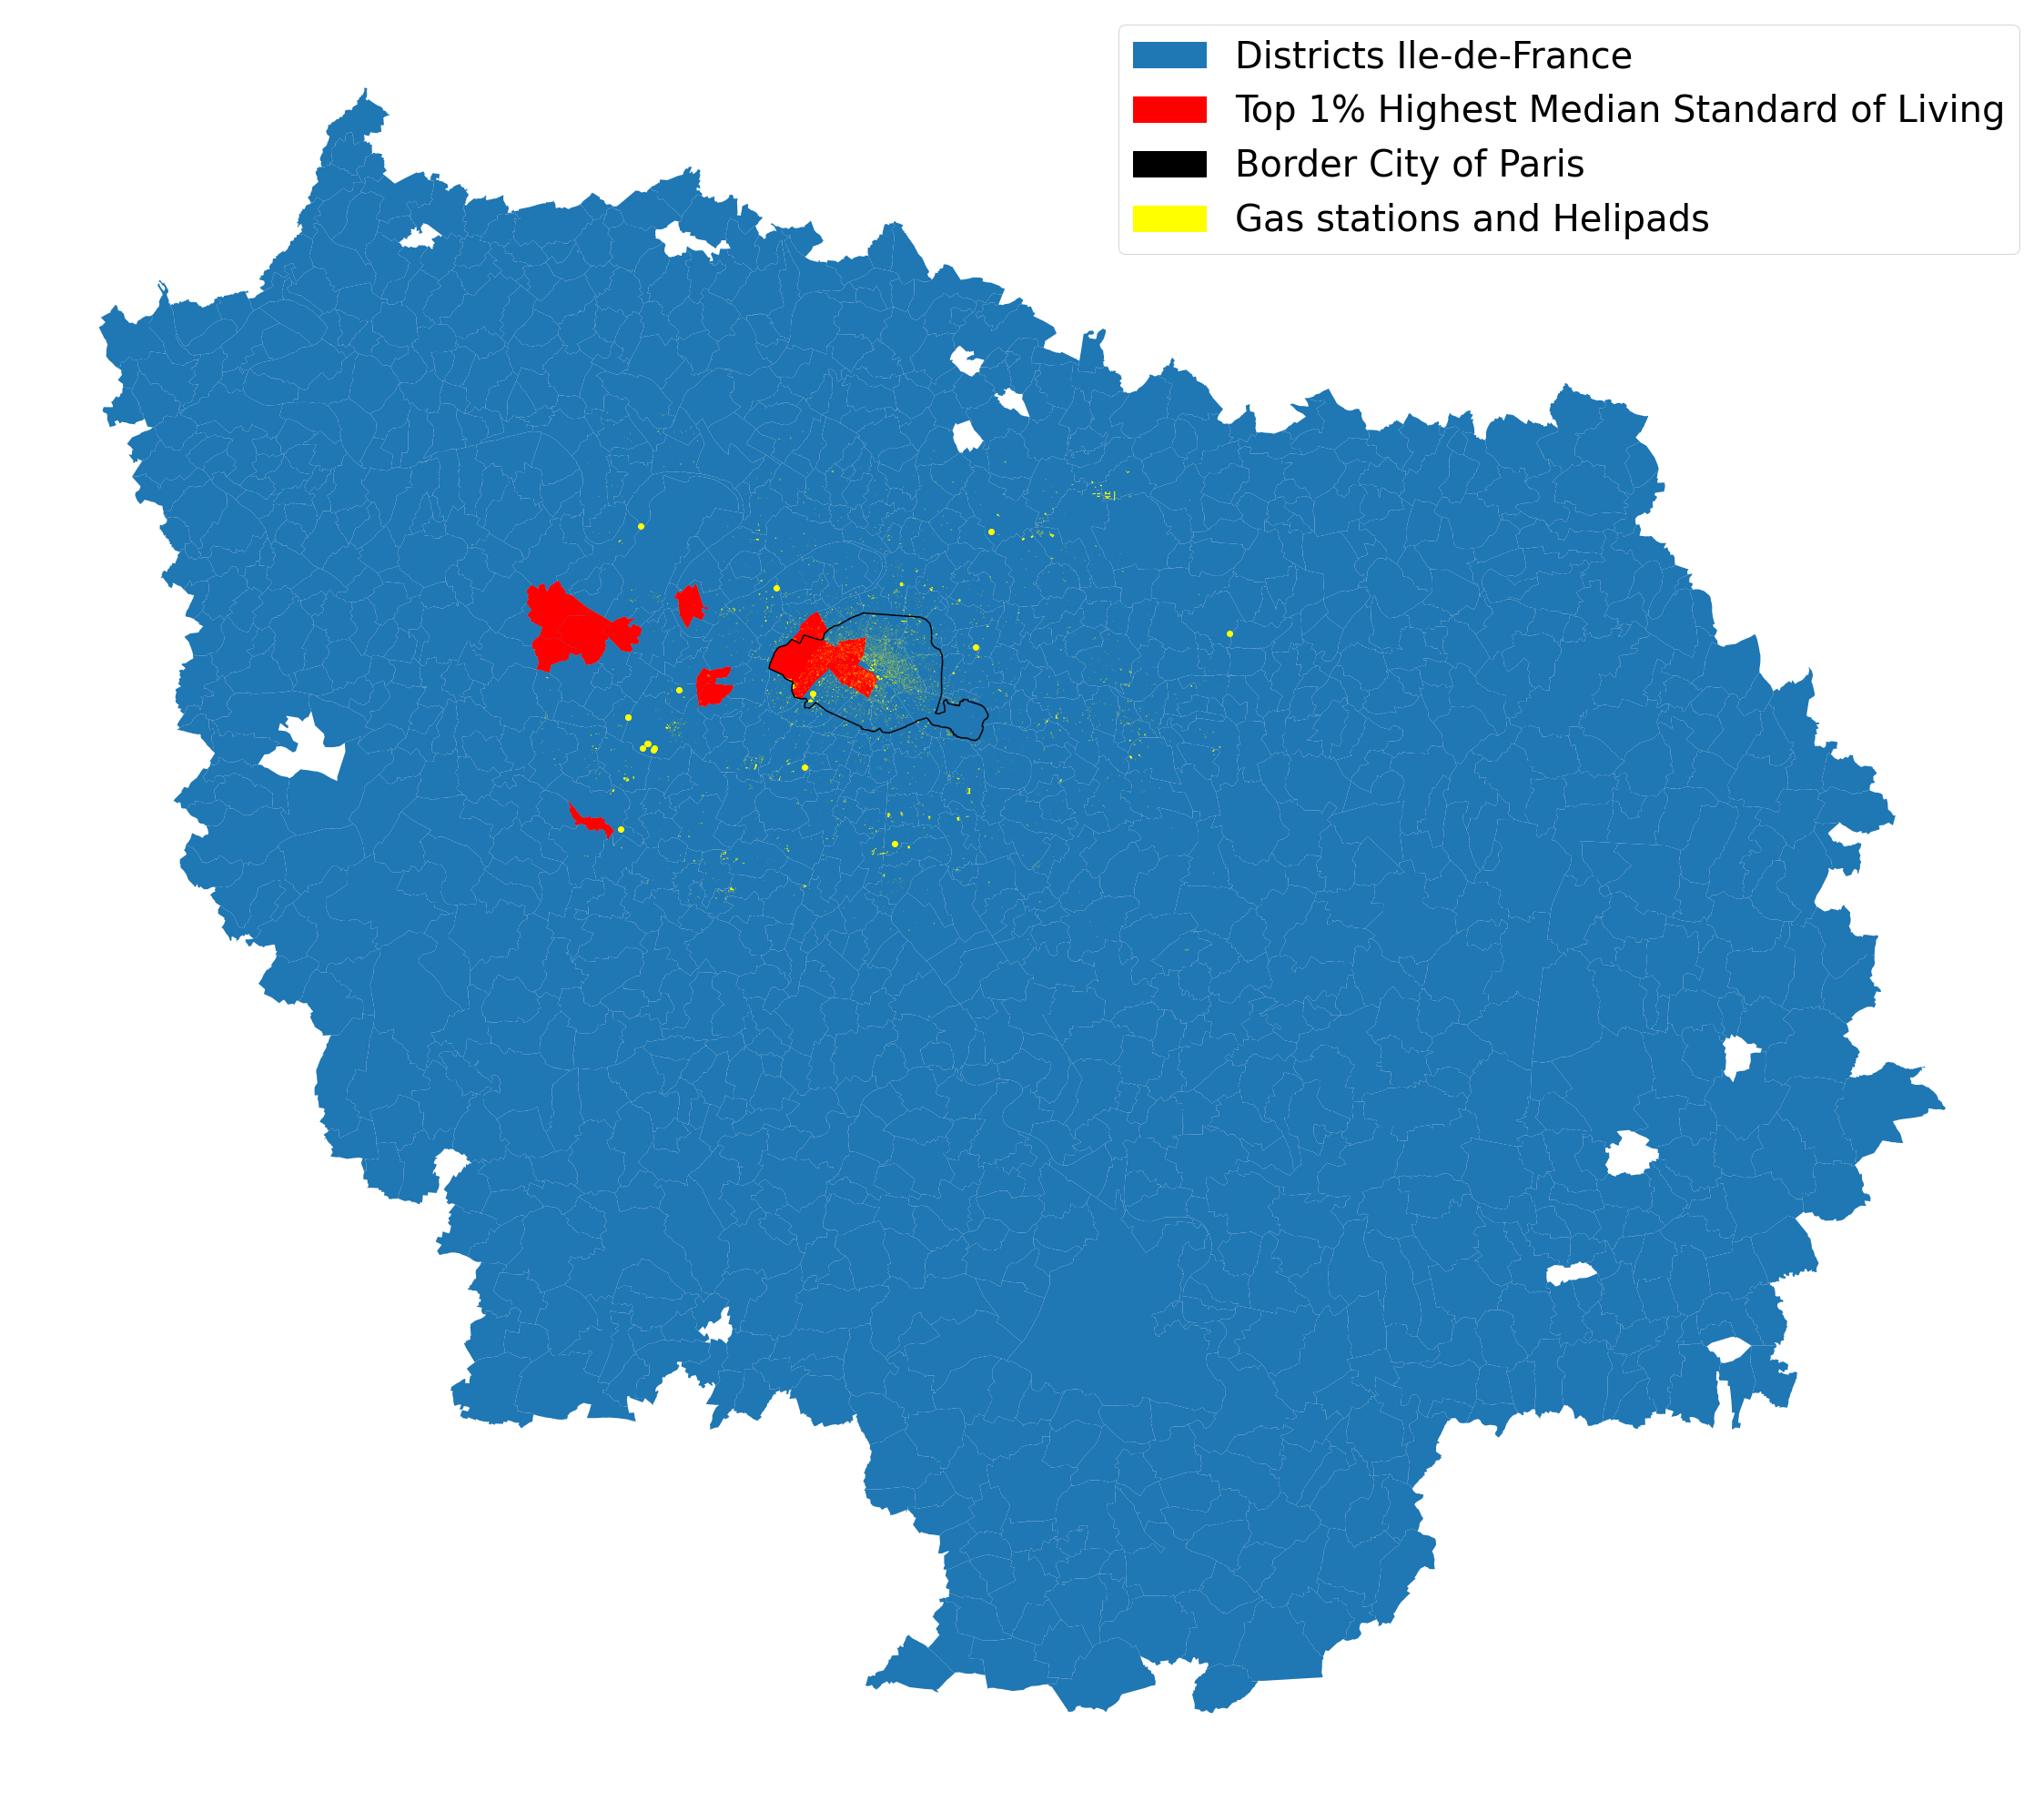

In [21]:
# Plot the Top 1% areas with highest median standard of living
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

paris_border = gpd.read_file('paris_boundary.shp')
top1 = round(len(median_jobs.index)*0.01)
sorted_median_jobs = median_jobs.astype({'MED17': 'float64', 'Job_densit': 'float64'})
sorted_median_jobs = sorted_median_jobs.sort_values(by=['MED17'], ascending=False, ignore_index=True)
sorted_median_jobs = sorted_median_jobs.iloc[0:top1,:]

ax = median_jobs.plot(figsize=[40,40])
sorted_median_jobs.plot(ax=ax, color='red')
paris_border.plot(ax=ax, color='black')
gas_station.plot(ax=ax, color='yellow')
blue_patch = mpatches.Patch(color='#1f77b4', label='Districts Ile-de-France')
red_patch = mpatches.Patch(color='red', label='Top 1% Highest Median Standard of Living')
black_patch = mpatches.Patch(color='black', label='Border City of Paris')
yellow_patch = mpatches.Patch(color='yellow', label='Gas stations and Helipads')
plt.legend(handles=[blue_patch, red_patch, black_patch, yellow_patch], prop={'size': 40})
ax.set_axis_off()
#plt.savefig('final_datasets/MedianStandardLiving.png', transparent=False)

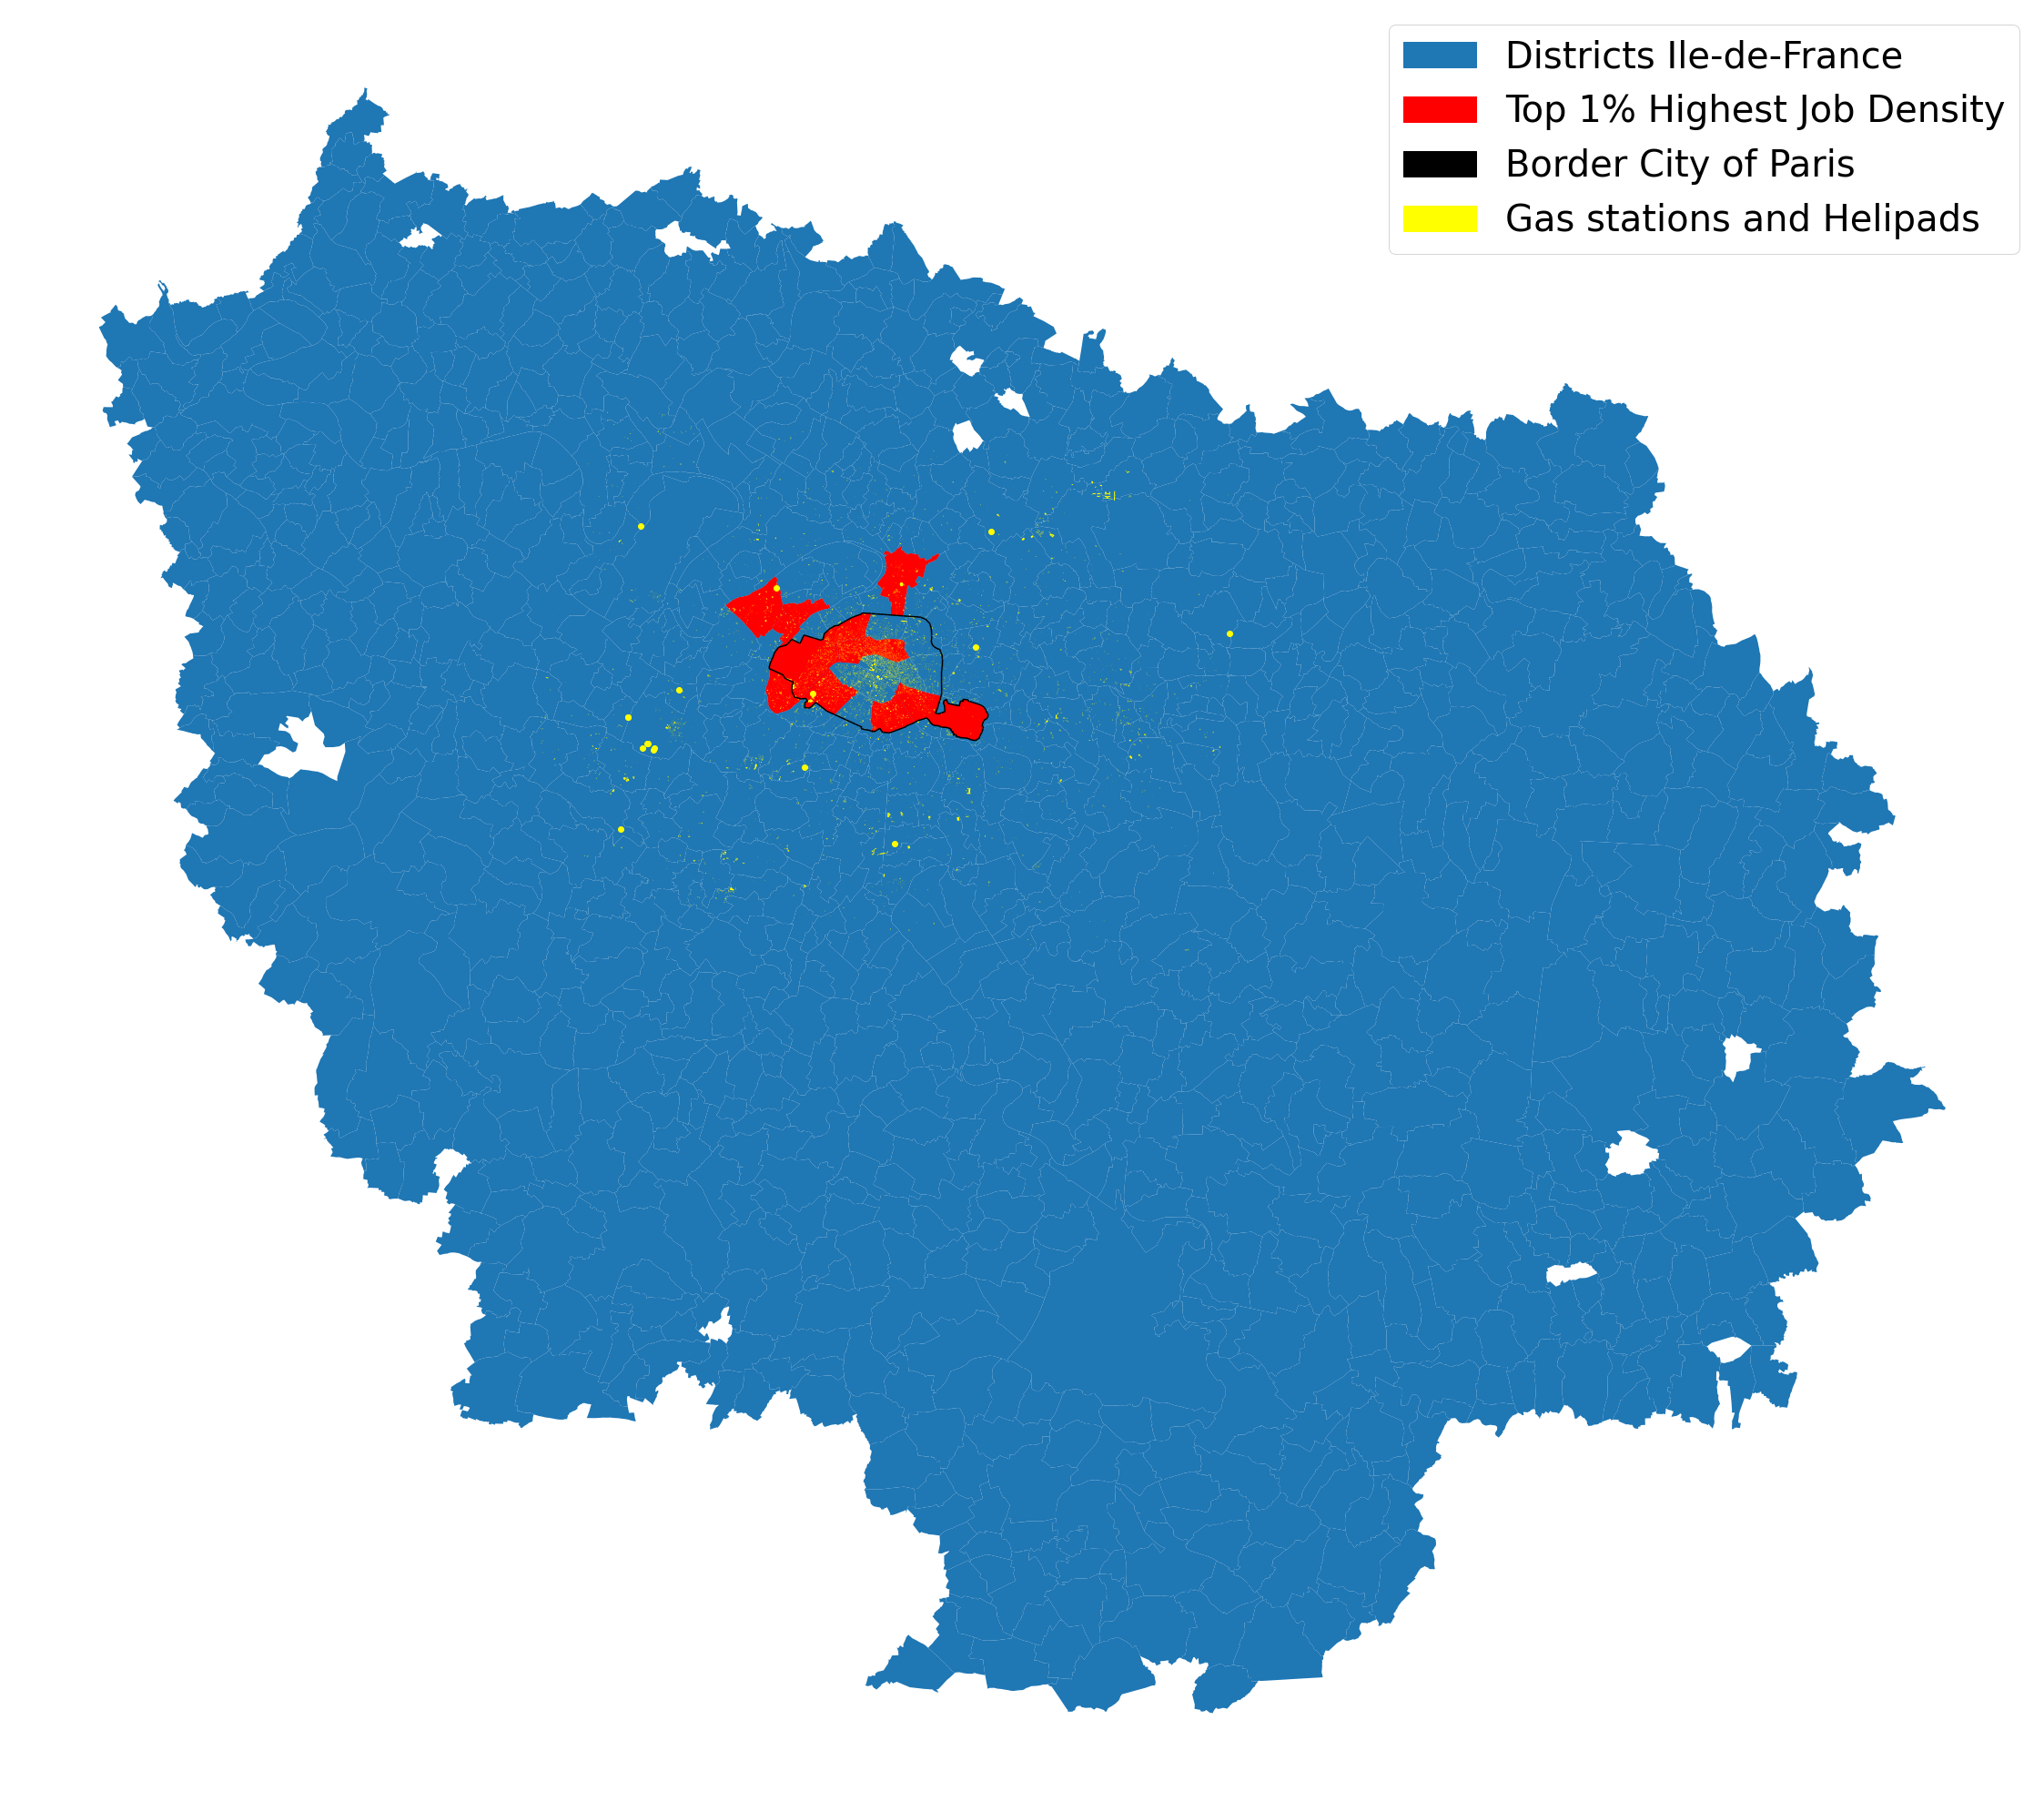

In [22]:
# Plot the Top 1% areas with highest job density
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

paris_border = gpd.read_file('paris_boundary.shp')
top1 = round(len(median_jobs.index)*0.01)
sorted_median_jobs = median_jobs.astype({'MED17': 'float64', 'Job_densit': 'float64'})
sorted_median_jobs = sorted_median_jobs.sort_values(by=['Job_densit'], ascending=False, ignore_index=True)
sorted_median_jobs = sorted_median_jobs.iloc[0:top1,:]

ax = median_jobs.plot(figsize=[40,40])
sorted_median_jobs.plot(ax=ax, color='red')
paris_border.plot(ax=ax, color='black')
gas_station.plot(ax=ax, color='yellow')

blue_patch = mpatches.Patch(color='#1f77b4', label='Districts Ile-de-France')
red_patch = mpatches.Patch(color='red', label='Top 1% Highest Job Density')
black_patch = mpatches.Patch(color='black', label='Border City of Paris')
yellow_patch = mpatches.Patch(color='yellow', label='Gas stations and Helipads')
plt.legend(handles=[blue_patch, red_patch, black_patch, yellow_patch], prop={'size': 40})
ax.set_axis_off()
#plt.savefig('final_datasets/Jobdensity.png', transparent=False)

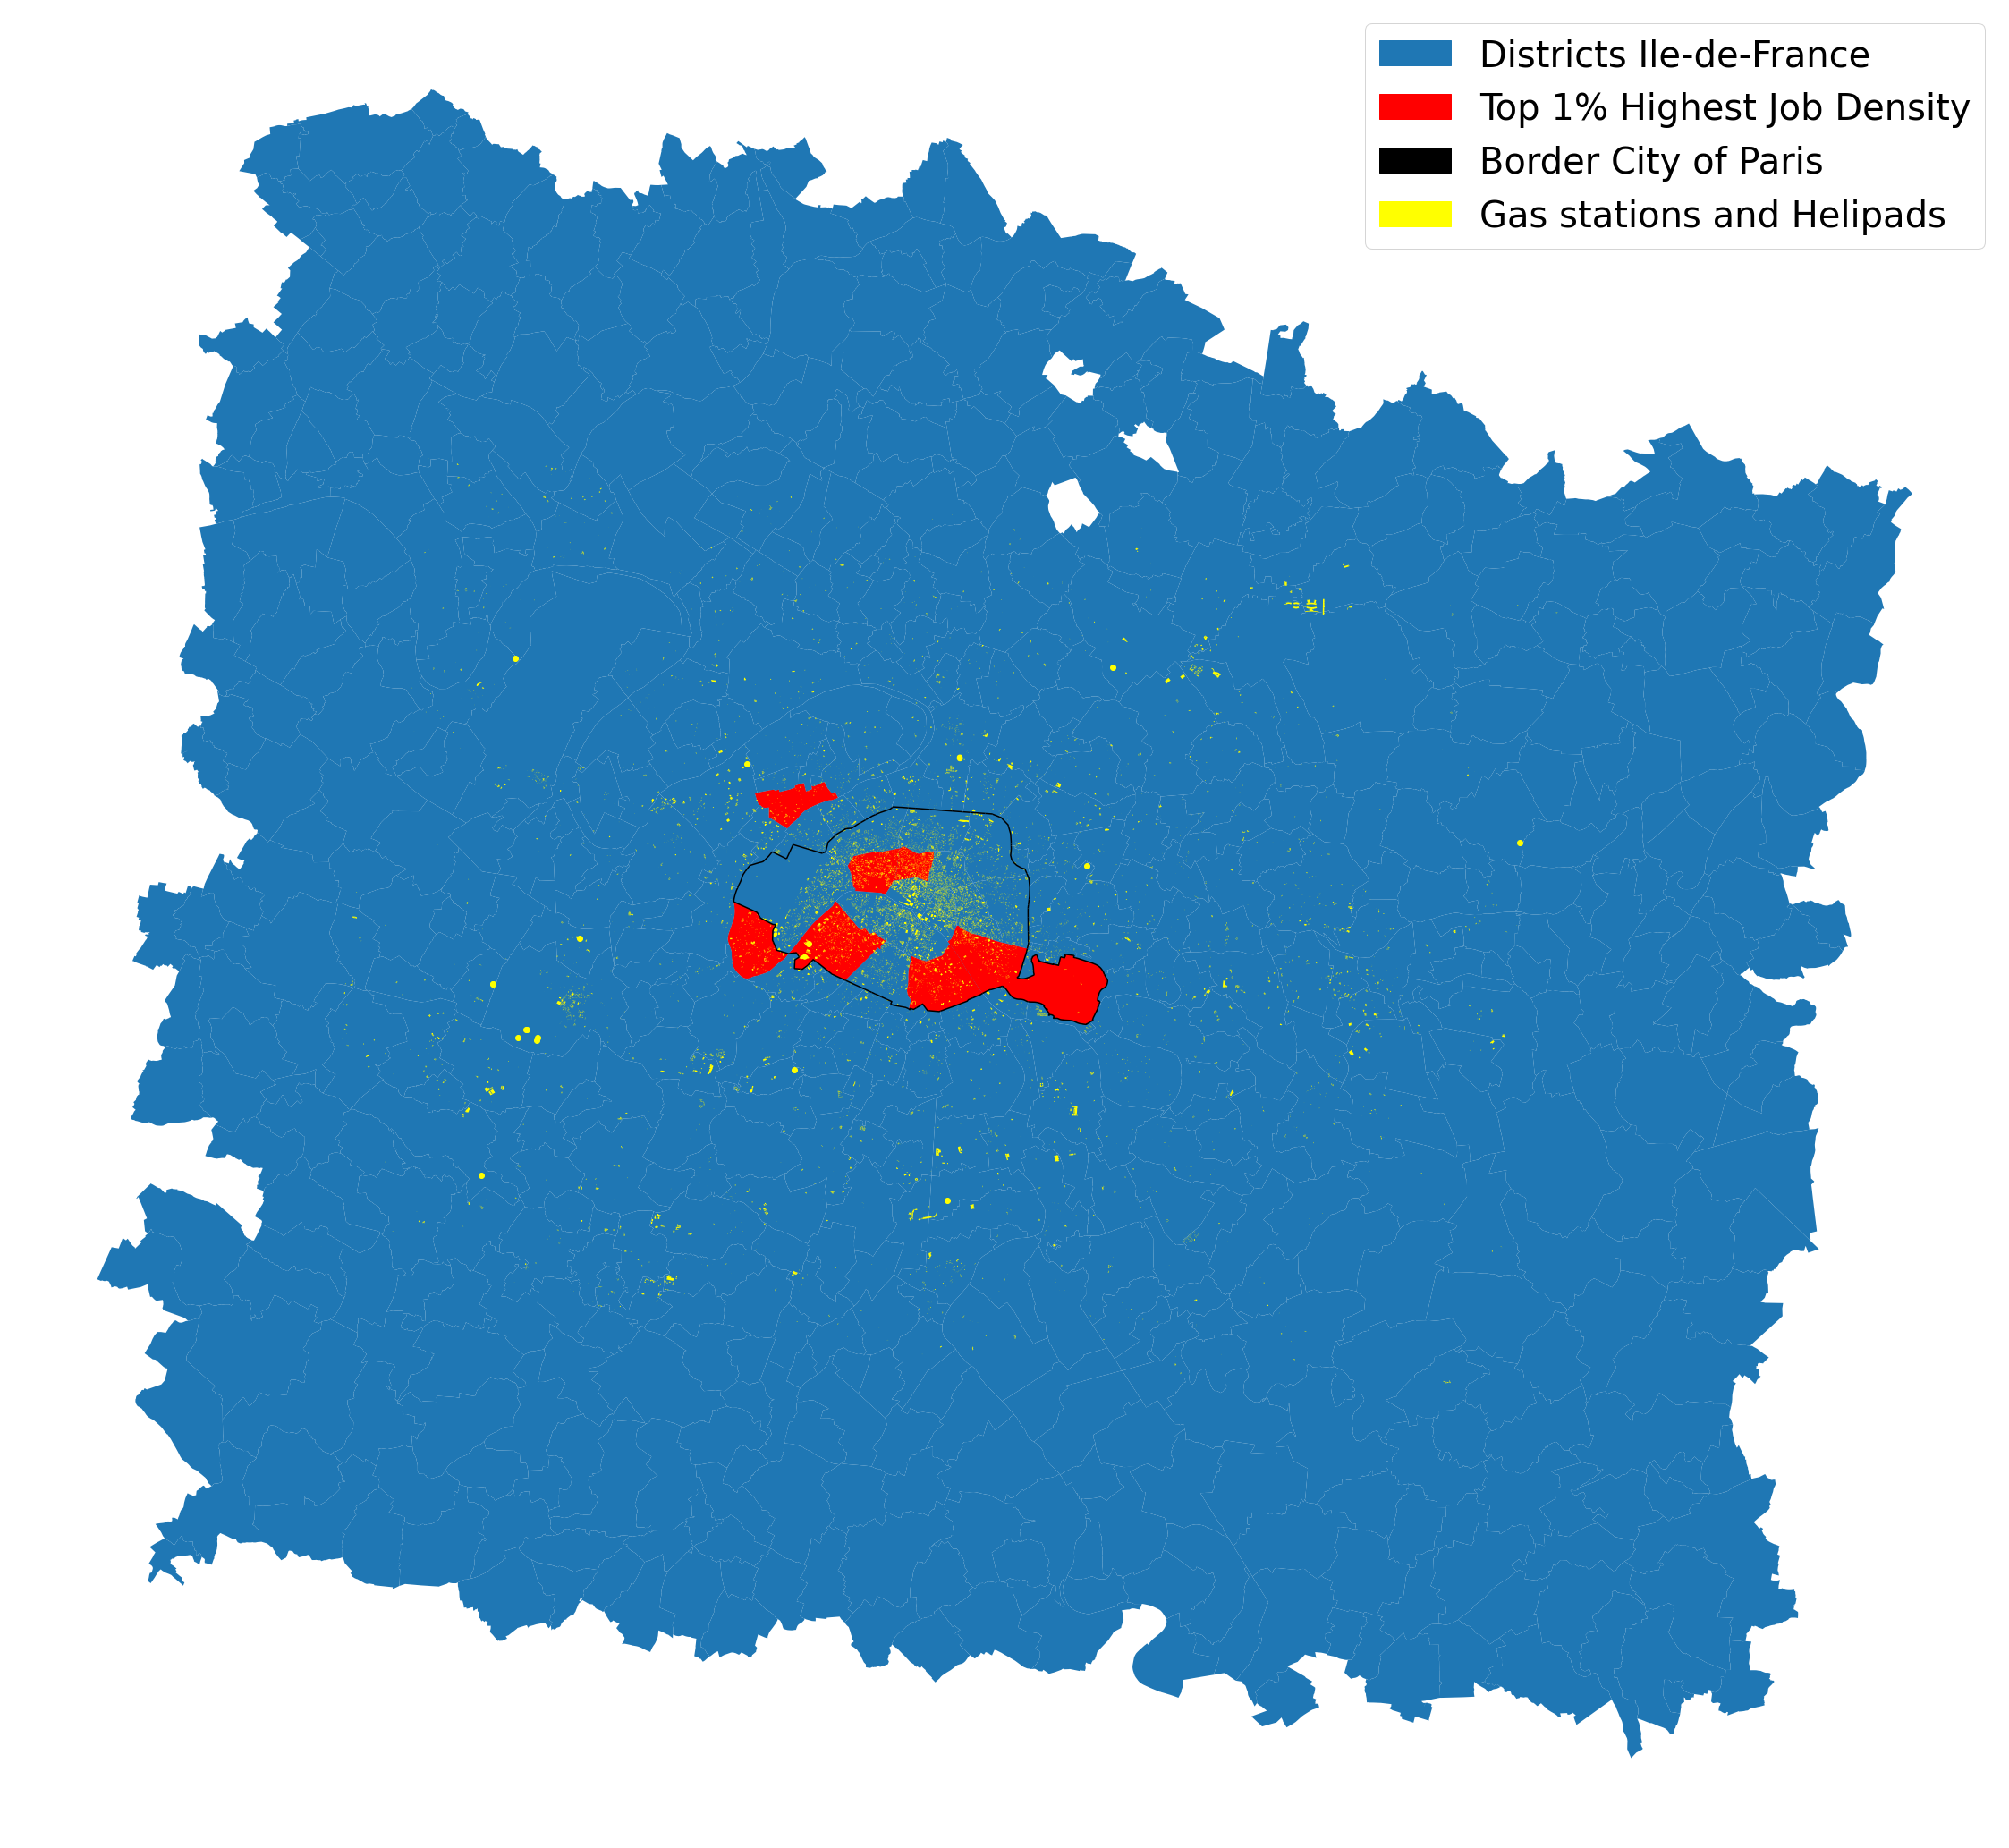

In [23]:
# Narrows down the area of interest and plots top1% with highest Job density in the narrowed down areas
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
area_of_interest = Polygon([(1.84, 48.5257), (1.84, 49.1907), (2.9581, 49.1907), (2.9581,48.5257)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[area_of_interest], crs=4326)
poly_gdf = poly_gdf.to_crs(epsg=3035)
clipped_job_density = gpd.clip(median_jobs, poly_gdf)
clipped_job_density = gpd.sjoin(median_jobs, clipped_job_density[['geometry','ref_INSEE']], op='within', how='inner')

paris_border = gpd.read_file('paris_boundary.shp')
top1 = round(len(clipped_job_density.index)*0.01)
sorted_median_jobs = clipped_job_density.astype({'MED17': 'float64', 'Job_densit': 'float64'})
sorted_median_jobs = sorted_median_jobs.sort_values(by=['Job_densit'], ascending=False, ignore_index=True)
sorted_median_jobs = sorted_median_jobs.iloc[0:top1,:]



ax = clipped_job_density.plot(figsize=[40,40])
sorted_median_jobs.plot(ax=ax, color='red')
paris_border.plot(ax=ax, color='black')
gas_station.plot(ax=ax, color='yellow')

blue_patch = mpatches.Patch(color='#1f77b4', label='Districts Ile-de-France')
red_patch = mpatches.Patch(color='red', label='Top 1% Highest Job Density')
black_patch = mpatches.Patch(color='black', label='Border City of Paris')
yellow_patch = mpatches.Patch(color='yellow', label='Gas stations and Helipads')
plt.legend(handles=[blue_patch, red_patch, black_patch, yellow_patch], prop={'size': 40})
ax.set_axis_off()
#plt.savefig('final_datasets/Jobdensity.png', transparent=False)

In [24]:
# Shows the top 4 boroughs of Paris with highest job density
paris = paris.astype({'MED17': 'float64', 'Job_densit': 'float64'})
paris.sort_values(by=['Job_densit'], ascending=False, ignore_index=True, inplace=True)
paris.iloc[:4,:]

name ref_INSEE    MED17  Job_densit  \
0   Paris 8e Arrondissement     75108  41270.0    220596.0   
1  Paris 15e Arrondissement     75115  30880.0    156255.0   
2   Paris 9e Arrondissement     75109  33980.0    130443.0   
3  Paris 13e Arrondissement     75113  24110.0    114095.0   

                                            geometry  
0  POLYGON ((3759251.629 2892650.612, 3759249.426...  
1  POLYGON ((3754002.905 2887655.394, 3754190.319...  
2  POLYGON ((3760881.404 2892507.715, 3760885.117...  
3  POLYGON ((3760065.391 2885098.267, 3760054.258...

In [25]:
# Shows the top 5 areas in Ile-de-France with the highest job density 
sorted_median_jobs.iloc[:5,:]

name ref_INSEE_left    MED17  Job_densit  \
0   Paris 8e Arrondissement          75108  41270.0    220596.0   
1  Paris 15e Arrondissement          75115  30880.0    156255.0   
2   Paris 9e Arrondissement          75109  33980.0    130443.0   
3                Courbevoie          92026  29540.0    121618.0   
4  Paris 13e Arrondissement          75113  24110.0    114095.0   

                                            geometry  index_right  \
0  POLYGON ((3759251.629 2892650.612, 3759249.426...         1269   
1  POLYGON ((3754002.905 2887655.394, 3754190.319...         1253   
2  POLYGON ((3760881.404 2892507.715, 3760885.117...         1263   
3  POLYGON ((3753331.030 2895385.072, 3753368.246...          268   
4  POLYGON ((3760065.391 2885098.267, 3760054.258...         1260   

  ref_INSEE_right  
0           75108  
1           75115  
2           75109  
3           92026  
4           75113

# Noisemaps

The noise data is from the environmental organisation Bruitparif and can be found here: https://carto.bruitparif.fr/

Data description: https://www.bruitparif.fr/carto/isophones/Vue%20globale/E3-agglos/Descriptif%20CSB.pdf

In [26]:
# Classe corresponds to the noise level represented in class of 5 in 5 decibels (in dB(A)) i.e. 
# a value of 40 means 40-45 decibels
noiseParis = gpd.read_file('noiseParis/A_Multi_Lden_Agglo.shp')
noiseParis = noiseParis[['Classe', 'geometry']]
noiseParis = noiseParis.to_crs(epsg=3035)
noiseParis.head()

Classe                                           geometry
0      40  POLYGON ((3728937.069 2889246.866, 3728938.201...
1      60  POLYGON ((3729401.034 2889198.082, 3729400.841...
2       0  POLYGON ((3730838.980 2889062.416, 3730844.885...
3       0  POLYGON ((3730878.309 2889053.599, 3730856.769...
4      45  POLYGON ((3733206.461 2888829.224, 3733201.487...

In [27]:
if gas_station.crs == noiseParis.crs:
    noise_joined = gpd.sjoin(gas_station, noiseParis, how='left', op='intersects')
else:
    print('The projections do not match!')

In [28]:
# group noise data by id and calculate the mean - then merge the result with the gas station dataset
noise_mean = noise_joined.groupby('id', as_index=False)['Classe'].mean()
gas_station = gas_station.merge(noise_mean, on='id', how='left')
gas_station.rename(columns={'Classe': 'Noise'}, inplace=True)
gas_station.head()

id                                           geometry  \
0  24285905  POLYGON ((3775888.076 2904965.056, 3776025.449...   
1  26334246  POLYGON ((3768276.452 2891346.568, 3768421.887...   
2  31964247  POLYGON ((3758646.508 2896730.118, 3758646.973...   
3  44071041  POLYGON ((3772203.380 2898184.237, 3772232.564...   
4  45250985  POLYGON ((3770085.960 2870423.888, 3770085.274...   

   Population_density    MED17  Job_densit      Noise  
0                 NaN  24290.0     36842.0  68.571429  
1              8013.0  16660.0     12074.0  68.000000  
2              4015.0  24990.0     24542.0  68.333333  
3              9724.0  17480.0     24421.0  65.000000  
4              4510.0  25210.0      5197.0  57.500000

In [29]:
# Plot noise data but first reduce the number of classes by grouping some classes together
interest_area = gpd.clip(noiseParis, poly_gdf)
def colorclass(row):
    li = [45, 50, 55, 60, 65, 70, 75, 80]
    if row['Classe'] < 45:
        return li[0]
    elif row['Classe'] >= 45 and row['Classe'] <=50:
        return li[1]
    elif row['Classe'] > 50 and row['Classe'] <=55:
        return li[2]
    elif row['Classe'] > 55 and row['Classe'] <=60:
        return li[3]
    elif row['Classe'] > 60 and row['Classe'] <=65:
        return li[4]
    elif row['Classe'] > 65 and row['Classe'] <=70:
        return li[5]
    elif row['Classe'] > 70 and row['Classe'] <=75:
        return li[6]
    else:
        return li[7]
interest_area['Colorclass'] = interest_area.apply(colorclass, axis=1)
paris_area = gpd.read_file('paris.geojson')
paris_area = paris_area.to_crs(epsg=3035)
noise_city = gpd.clip(noiseParis, paris_area)
noise_city['Colorclass'] = noise_city.apply(colorclass, axis=1)

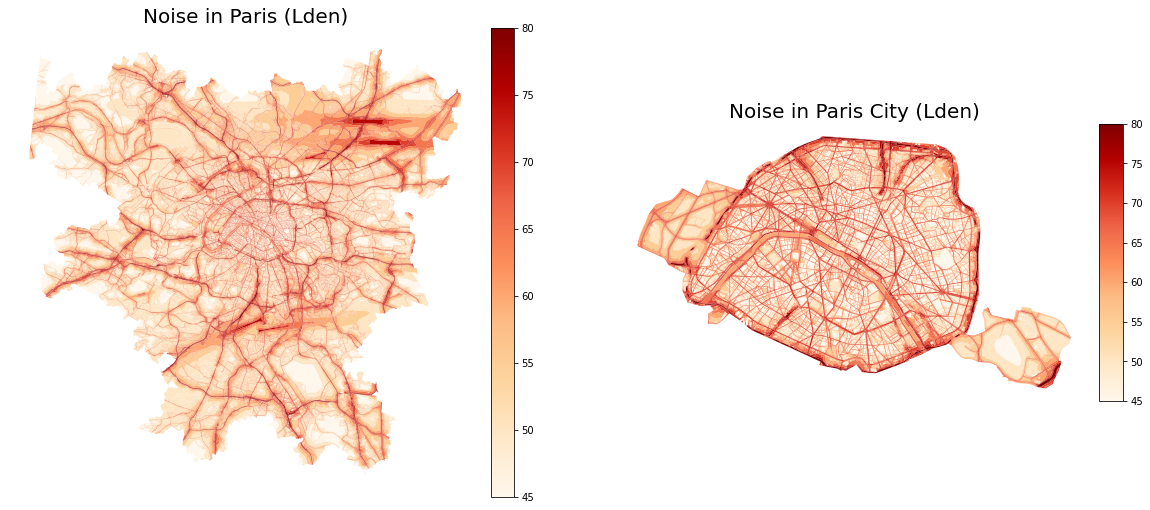

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20,20])
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
interest_area.plot(column='Colorclass', 
                   cmap='OrRd', 
                   ax=ax1, 
                   legend=True,
                   cax=cax1)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.1)
noise_city.plot(column='Colorclass', 
                   cmap='OrRd', 
                   ax=ax2, 
                   legend=True,
                   cax=cax2)
ax1.set_title('Noise in Paris (Lden)', fontsize=20)
ax1.set_axis_off()
ax2.set_title('Noise in Paris City (Lden)', fontsize=20)
ax2.set_axis_off()
#plt.savefig('final_datasets/Noise_Lden.png', transparent=False)

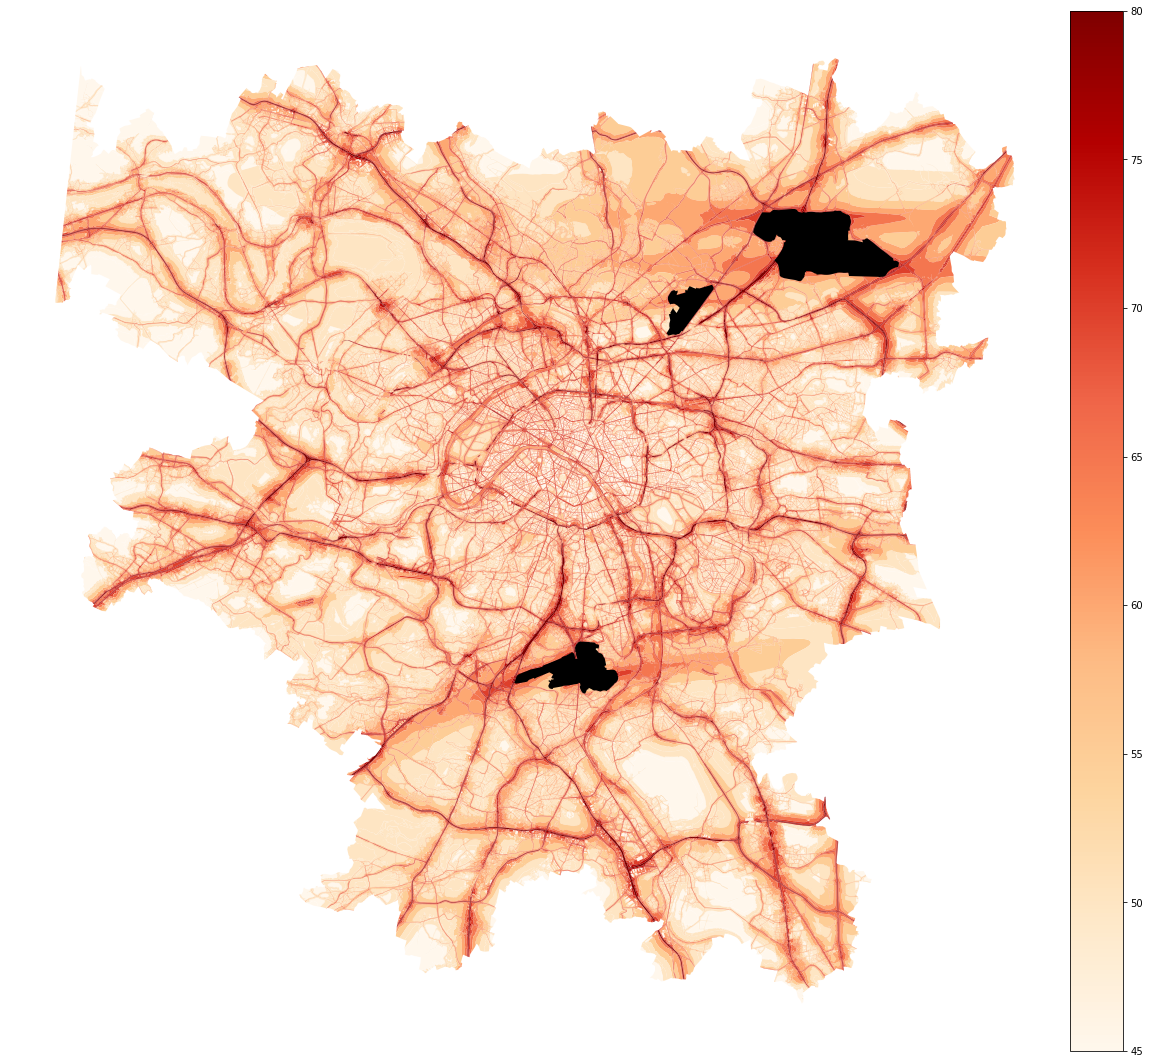

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=[20, 20])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
interest_area.plot(column='Colorclass', 
                   cmap='OrRd', 
                   ax=ax, 
                   legend=True,
                   cax=cax)
airports = gpd.read_file('airports_and_trainstations/airports.shp')
airports.plot(ax=ax, color='black')
ax.set_axis_off()
#plt.savefig('Noise_Lden_2.png', transparent=False)

# Points of Interest
The points of interest data was created by taking the Top20 points of Interest & Landmarks in Paris as well as the Top20 attractions in Paris from tripadvisor and creating a shapefile with these points manually in QGIS.

Points of Interest & Landmarks in Paris: https://www.tripadvisor.com/Attractions-g187147-Activities-c47-t163-Paris_Ile_de_France.html

Attractions: https://www.tripadvisor.com/Attractions-g187147-Activities-a_allAttractions.true-Paris_Ile_de_France.html

In [32]:
import geopandas as gpd
pI = gpd.read_file("Points_of_Interest/Points_of_Interest.shp")
pI = pI.to_crs(epsg=3035)

In [33]:
# create a 1.5km buffer around the points of interest
pI['geometry'] = pI['geometry'].buffer(1500) 

In [34]:
# join gas station data with point of interest (PoI) data and calculate the number of intersections 
# with a 1.5km buffer PoI per gas station
pI.drop('id', axis=1, inplace=True)
if gas_station.crs == pI.crs:
    gas_pI = gpd.sjoin(gas_station, pI, op='intersects', how='left')
    gas_pI.dropna(subset=['Name'], axis=0, inplace=True)
    gas_pI['Num_of_PoI'] = 1
    gas_pI = gas_pI.groupby('id', as_index=False)['Num_of_PoI'].sum()
else:
    print('The projections do not match!')

In [35]:
# Every gas station which has no Point of interest within a radius of 1.5km gets assigned a value of zero  
gas_station = gas_station.merge(gas_pI, on='id', how='left')
gas_station.loc[gas_station['Num_of_PoI'].isnull(), 'Num_of_PoI'] = 0
gas_station.head()

id                                           geometry  \
0  24285905  POLYGON ((3775888.076 2904965.056, 3776025.449...   
1  26334246  POLYGON ((3768276.452 2891346.568, 3768421.887...   
2  31964247  POLYGON ((3758646.508 2896730.118, 3758646.973...   
3  44071041  POLYGON ((3772203.380 2898184.237, 3772232.564...   
4  45250985  POLYGON ((3770085.960 2870423.888, 3770085.274...   

   Population_density    MED17  Job_densit      Noise  Num_of_PoI  
0                 NaN  24290.0     36842.0  68.571429         0.0  
1              8013.0  16660.0     12074.0  68.000000         0.0  
2              4015.0  24990.0     24542.0  68.333333         0.0  
3              9724.0  17480.0     24421.0  65.000000         0.0  
4              4510.0  25210.0      5197.0  57.500000         0.0

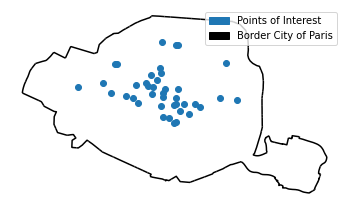

In [36]:
# plot POI
pI = gpd.read_file("Points_of_Interest/Points_of_Interest.shp")
pI = pI.to_crs(epsg=3035)

ax = paris_border.plot(color='black')
pI.plot(ax=ax)
blue_patch = mpatches.Patch(color='#1f77b4', label='Points of Interest')
black_patch = mpatches.Patch(color='black', label='Border City of Paris')
plt.legend(handles=[blue_patch, black_patch])
ax.set_axis_off()

#plt.savefig('final_datasets/PointsofInterest.png', transparent=False)

# Major Transport Node

The data for major transport nodes in paris was created by manually creating a shapefile in QGIS with the nine major train stations in Paris city and its surrounding area and the two international airports: Paris-Charles de Gaulle and Paris-Orly, as well as the airport Le Bourget which is mostly used for business aviation.

Major train stations according to the Official website of the Convention and Visitors Bureau Paris: https://en.parisinfo.com/practical-paris/getting-to-paris/arriving-in-paris-by-train

In [37]:
import geopandas as gpd
trains = gpd.read_file('airports_and_trainstations/train_stations.shp')
airports = gpd.read_file('airports_and_trainstations/airports.shp')

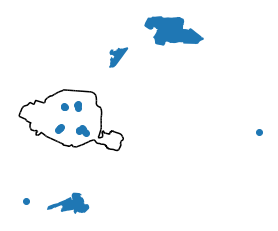

In [38]:
# plot train stations and airports of interest
ax = trains.plot()
airports.plot(ax=ax)
paris_border.plot(ax=ax, color='black')
ax.set_axis_off()

In [39]:
# merge train stations shapefile with airports shapefile 
if trains.crs == airports.crs:
    trains_and_airports = trains.append(airports, ignore_index=True)
else:
    print("The projections are not the same!")

In [40]:
trains_and_airports.head()

name                         geometry
0            Gare de Lyon  POINT (3762191.429 2888017.612)
1       Gare Montparnasse  POINT (3758170.337 2887906.748)
2                   Bercy  POINT (3762611.084 2887453.750)
3  Montparnasse-Bienvenüe  POINT (3758278.322 2888123.627)
4           Gare de l'Est  POINT (3761409.839 2891611.110)

In [41]:
# get distance gas stations and trains_and_airports
for j in range(len(trains_and_airports['geometry'])):
    gas_station[f'distance_{j}'] = gas_station.distance(trains_and_airports.loc[j, 'geometry'])

    
# The overflow warning only appears for trains_and_airports.loc[22,:] which is airport Paris-Orly 
# Since in the end only the minimum distance per row will be saved the overflow problem 
# in column 'distance_22' will be ignored

/home/shamrock/miniconda3/envs/sp-env/lib/python3.8/site-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)


In [42]:
# function gets min value per row and converts it from m to km
def get_min_distkm(row):
    return min(row)/1000

# get min distance in km, save it in column Major-Transport-Node, drop the 24 distance columns
gas_station['Major-Transport-Node'] = gas_station.filter(regex='distance').apply(get_min_distkm, axis=1)
gas_station.drop(list(gas_station.filter(regex='distance')), axis=1, inplace =True)
gas_station.head()

id                                           geometry  \
0  24285905  POLYGON ((3775888.076 2904965.056, 3776025.449...   
1  26334246  POLYGON ((3768276.452 2891346.568, 3768421.887...   
2  31964247  POLYGON ((3758646.508 2896730.118, 3758646.973...   
3  44071041  POLYGON ((3772203.380 2898184.237, 3772232.564...   
4  45250985  POLYGON ((3770085.960 2870423.888, 3770085.274...   

   Population_density    MED17  Job_densit      Noise  Num_of_PoI  \
0                 NaN  24290.0     36842.0  68.571429         0.0   
1              8013.0  16660.0     12074.0  68.000000         0.0   
2              4015.0  24990.0     24542.0  68.333333         0.0   
3              9724.0  17480.0     24421.0  65.000000         0.0   
4              4510.0  25210.0      5197.0  57.500000         0.0   

   Major-Transport-Node  
0              0.000000  
1              6.784346  
2              4.792038  
3              3.773840  
4              7.884928

# No fly zone

The entire metropolitan area of Paris is in a prohibited airspace where it is not allowed to fly lower than 6500ft. There is another prohibited airspace in the southwest of the city. These prohibited areas (P25 and P23) were taken from the aeronautical chart given by the french government found here: https://www.geoportail.gouv.fr/donnees/carte-oaci-vfr and then manually created as a shapefile in QGIS.

In [43]:
paris_P23 = gpd.read_file('No-fly-zones_Paris/P23_Paris.shp')
paris_P25 = gpd.read_file('No-fly-zones_Paris/P25.shp')
print(f'All data have same crs: {paris_P23.crs == paris_P25.crs == gas_station.crs}')

All data have same crs: True


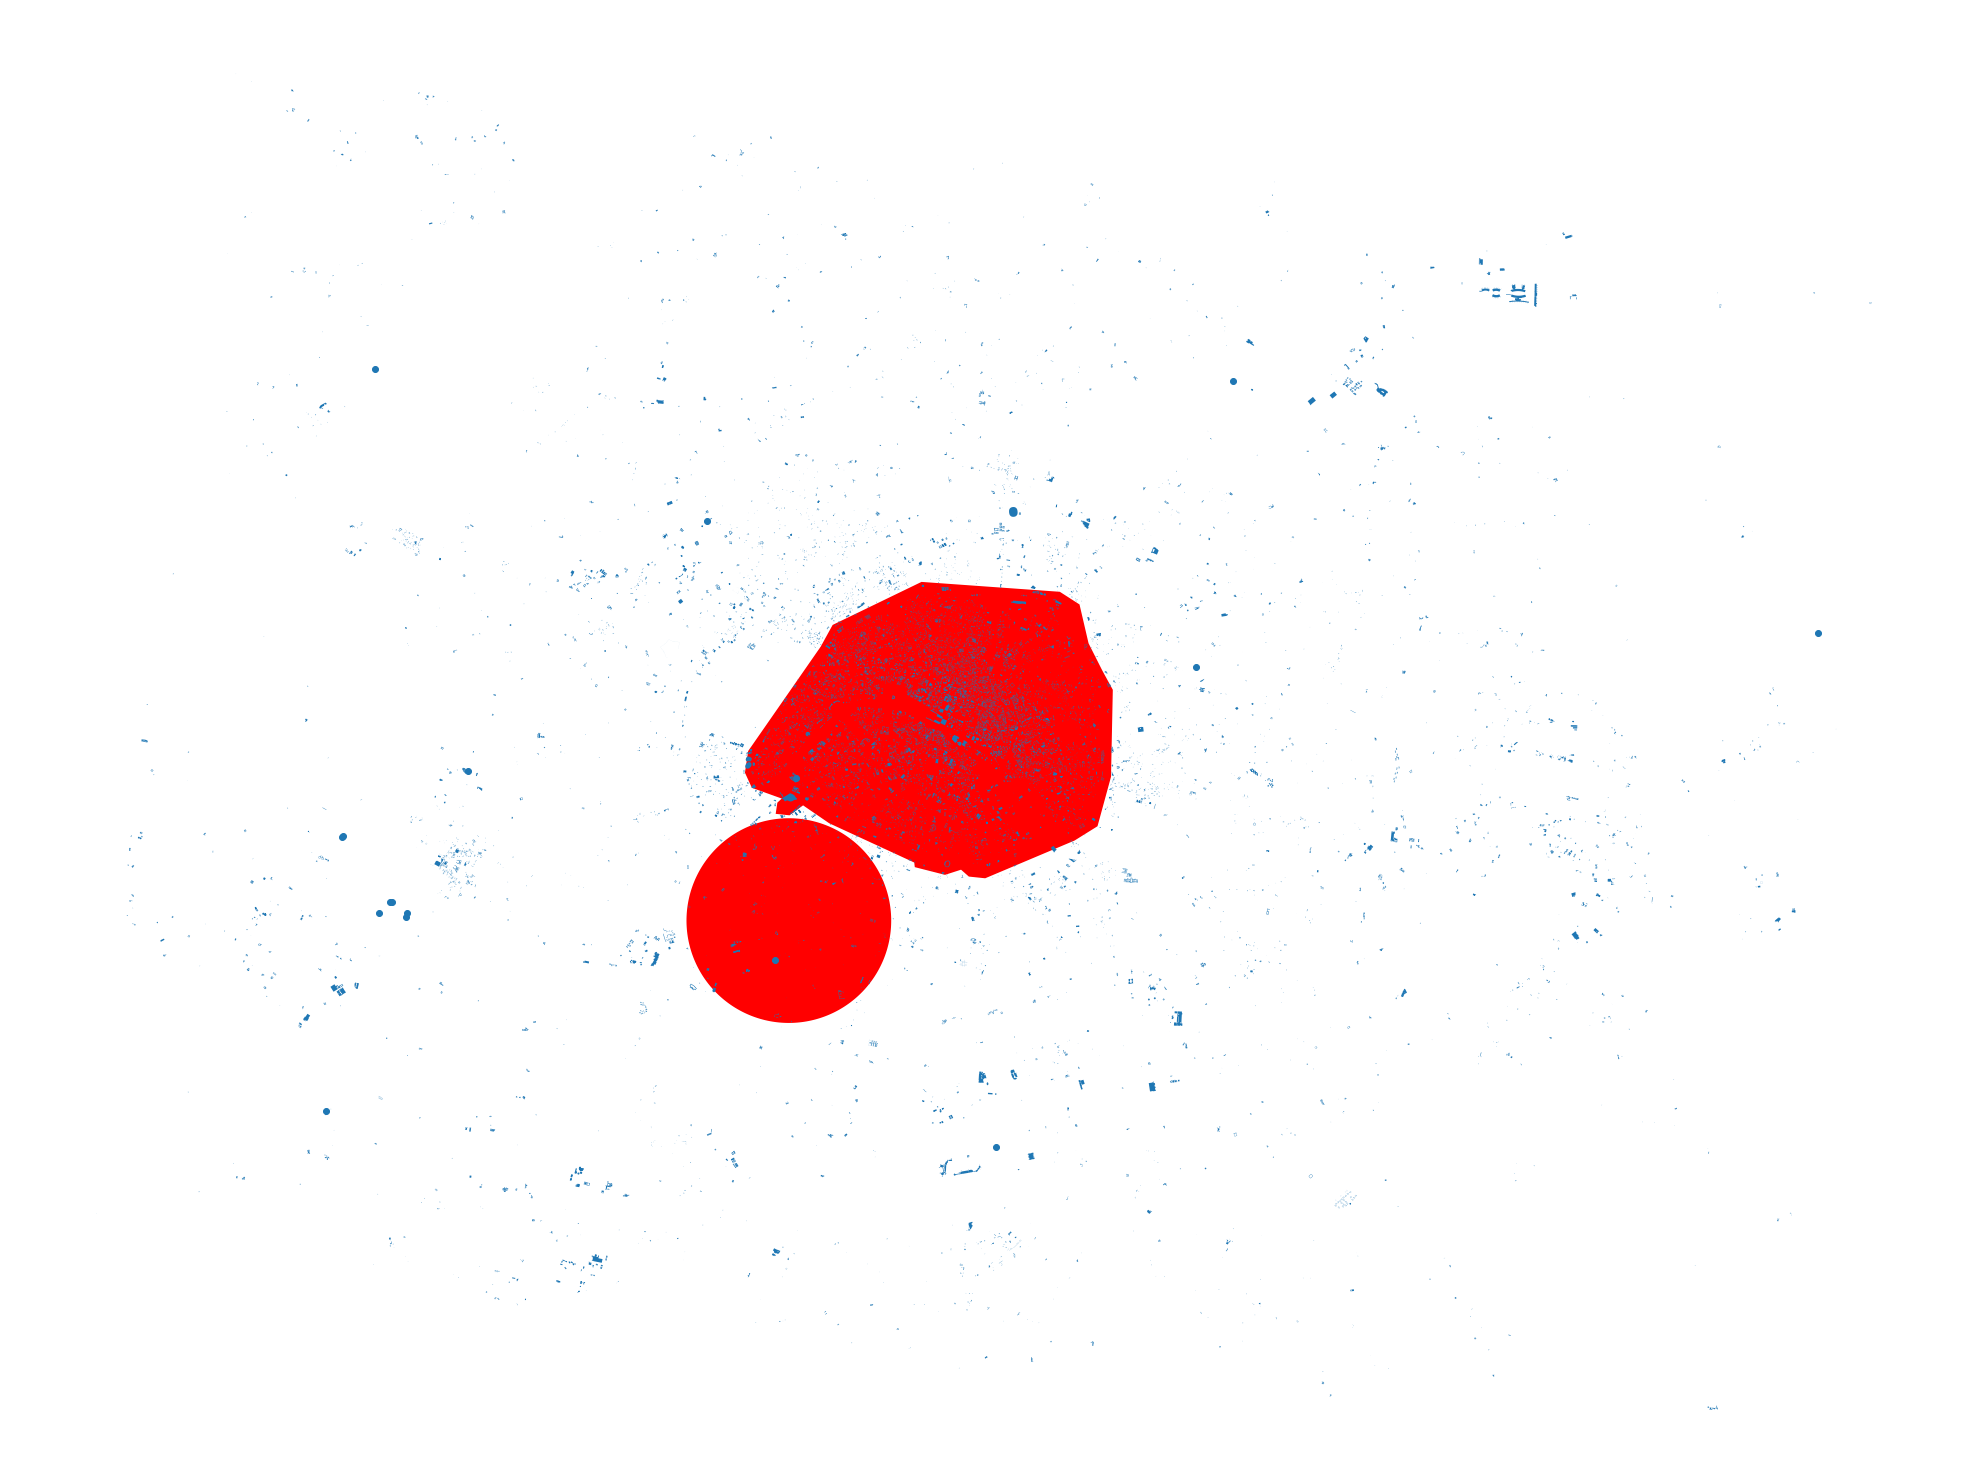

In [44]:
# Plot of gas stations and No-fly-zones P23, P25
ax = paris_P23.plot(figsize=[35,35], facecolor='none', color='red')
paris_P25.plot(ax=ax, color='red')
gas_station.plot(ax=ax)
ax.set_axis_off()

In [45]:
# clip areas of gas stations inside the no-fly-zones
inP23 = gpd.clip(gas_station, paris_P23)
inP25 = gpd.clip(gas_station, paris_P25)

In [46]:
# add column no-fly-zone and assign value 0 for yes, inside a no-fly-zone 
inP23['No-fly-Zone'] = 0
inP25['No-fly-Zone'] = 0

In [47]:
# combine the two datasets inP23 and inP25
inP25orP23 = inP23.append(inP25)
inP25orP23 = inP25orP23[['id', 'No-fly-Zone']]

In [48]:
# merge gas station data with no-fly-zone data
gas_station = gas_station.merge(inP25orP23, on='id', how='left')
gas_station.loc[gas_station['No-fly-Zone'].isnull(), 'No-fly-Zone'] = 1
gas_station.head()

id                                           geometry  \
0  24285905  POLYGON ((3775888.076 2904965.056, 3776025.449...   
1  26334246  POLYGON ((3768276.452 2891346.568, 3768421.887...   
2  31964247  POLYGON ((3758646.508 2896730.118, 3758646.973...   
3  44071041  POLYGON ((3772203.380 2898184.237, 3772232.564...   
4  45250985  POLYGON ((3770085.960 2870423.888, 3770085.274...   

   Population_density    MED17  Job_densit      Noise  Num_of_PoI  \
0                 NaN  24290.0     36842.0  68.571429         0.0   
1              8013.0  16660.0     12074.0  68.000000         0.0   
2              4015.0  24990.0     24542.0  68.333333         0.0   
3              9724.0  17480.0     24421.0  65.000000         0.0   
4              4510.0  25210.0      5197.0  57.500000         0.0   

   Major-Transport-Node  No-fly-Zone  
0              0.000000          1.0  
1              6.784346          1.0  
2              4.792038          1.0  
3              3.773840          1.0  
4              7.884928          1.0

In [49]:
gas_station.shape

(15156, 9)

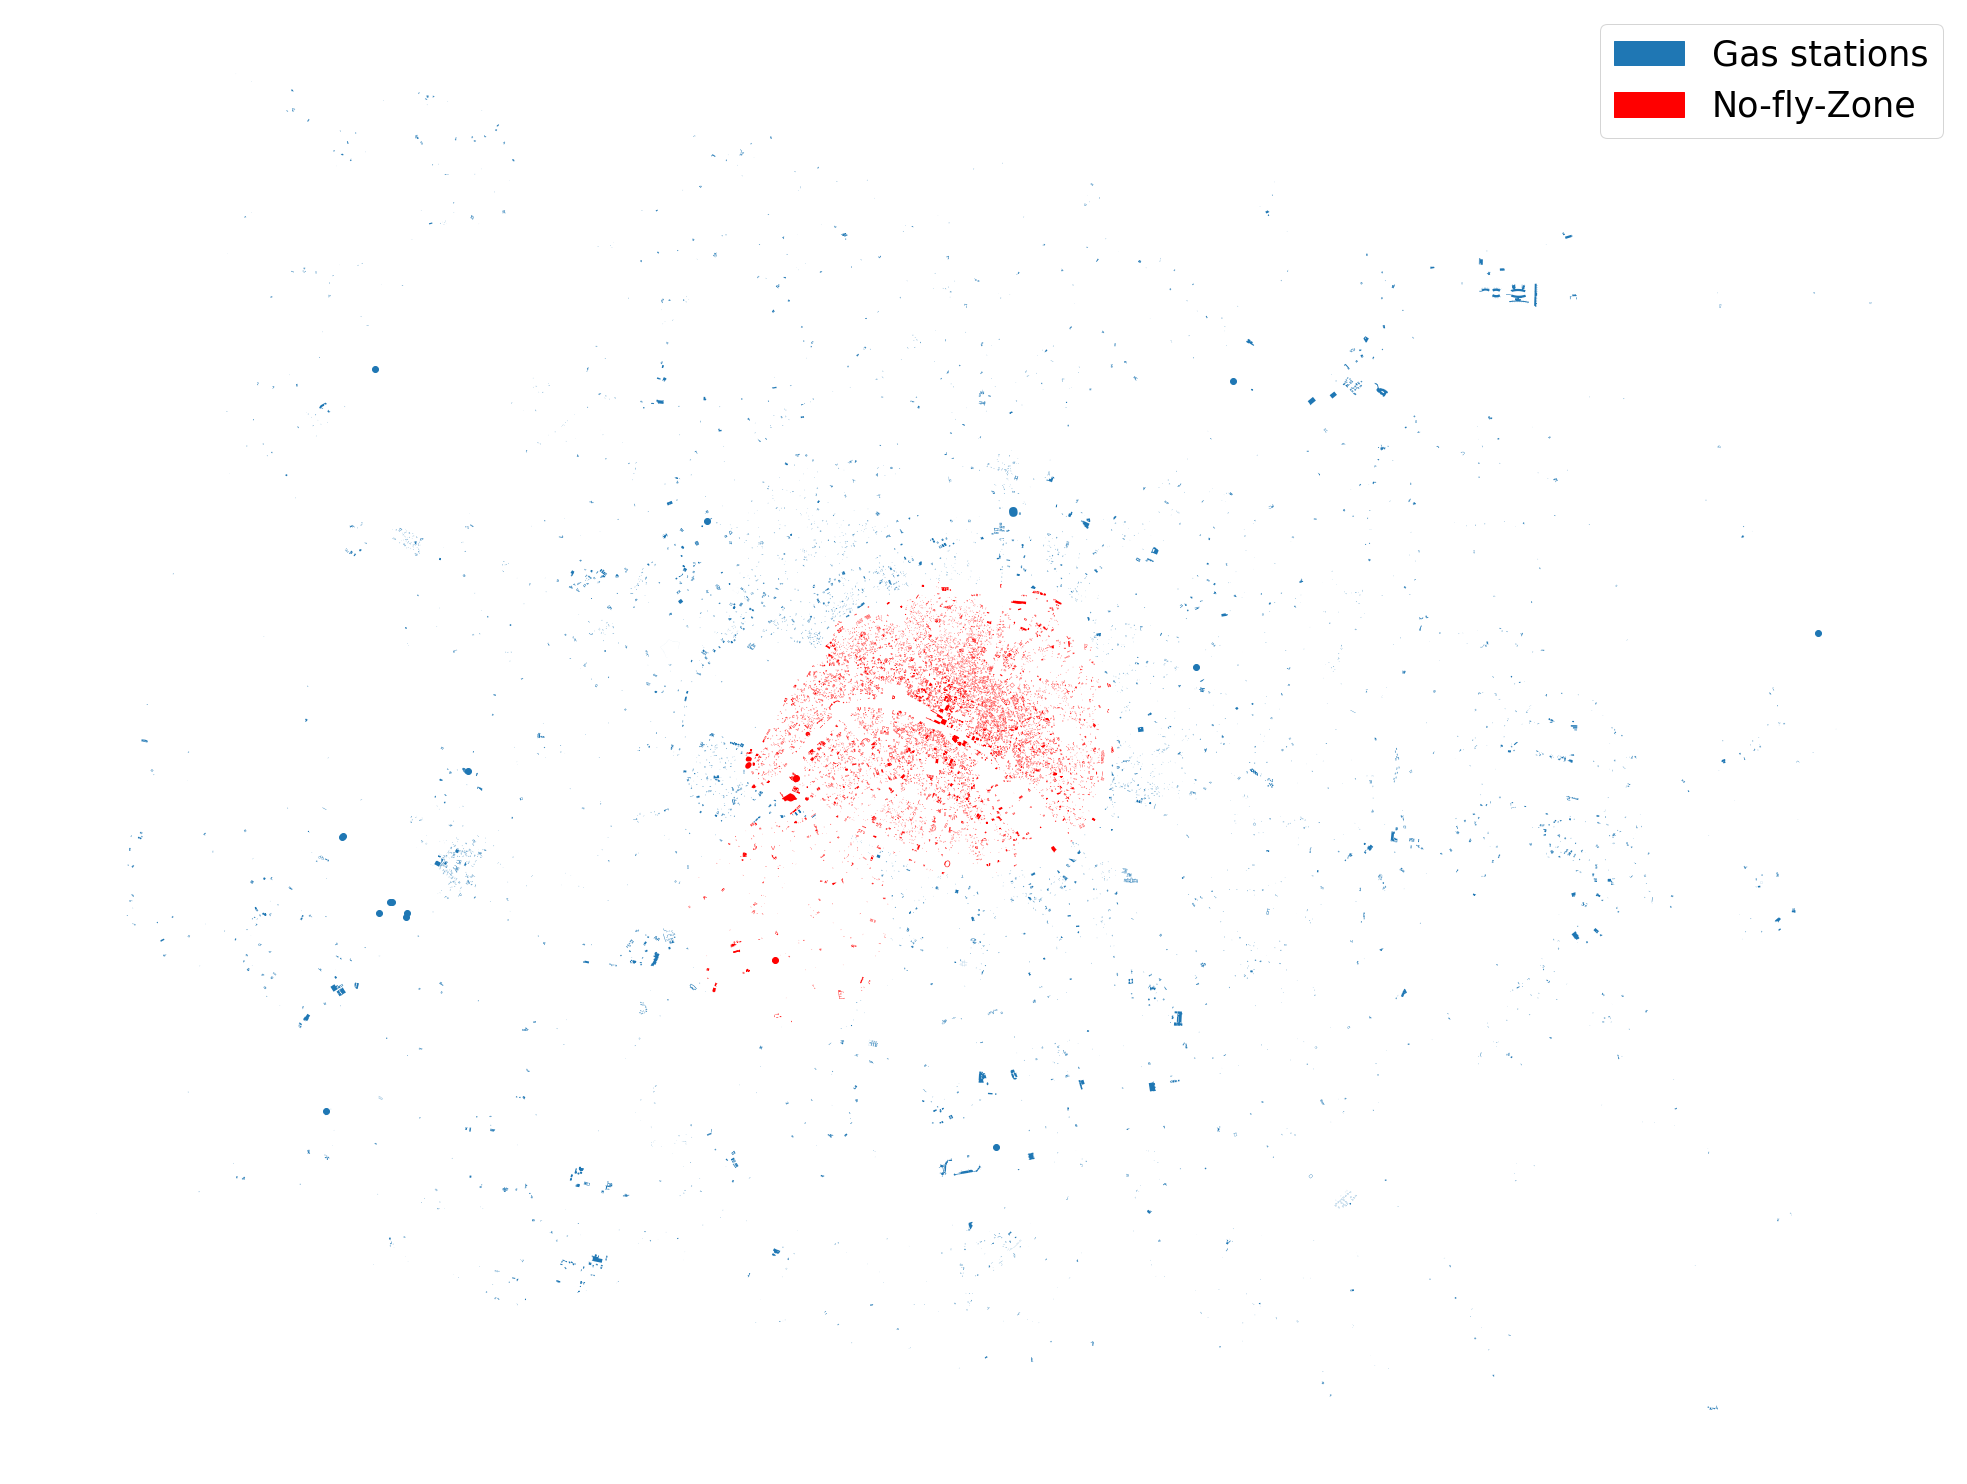

In [50]:
# Plot gas stations
import matplotlib.patches as mpatches

ax = gas_station.loc[gas_station['No-fly-Zone']==0,].plot(figsize=[35,35], color='red')
gas_station.loc[gas_station['No-fly-Zone']==1,].plot(ax=ax)

blue_patch = mpatches.Patch(color='#1f77b4', label='Gas stations')
red_patch = mpatches.Patch(color='red', label='No-fly-Zone')
plt.legend(handles=[blue_patch, red_patch], prop={'size': 35})
ax.set_axis_off()

In [51]:
#gas_station.to_file('final_datasets/gas_stations.shp')